## Load Required Packages

In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import json
import math
from scipy import stats
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import QuantileTransformer
import concurrent.futures
from itertools import combinations
from tqdm import tqdm
from pyEDM import *

In [102]:
# Print package versions
import sys
!{sys.executable} -m pip list


Package                   Version     Editable project location
------------------------- ----------- -----------------------------------------------------------
anaconda-anon-usage       0.4.4
annotated-types           0.7.0
anyio                     4.2.0
appnope                   0.1.3
archspec                  0.2.3
arcosparse                0.4.2
argon2-cffi               21.3.0
argon2-cffi-bindings      21.2.0
asciitree                 0.3.3
astral                    3.2
asttokens                 2.0.5
async-lru                 2.0.4
attrs                     23.1.0
Babel                     2.11.0
beautifulsoup4            4.12.3
bleach                    4.1.0
boltons                   23.0.0
boto3                     1.39.1
botocore                  1.39.1
Bottleneck                1.6.0
brokenaxes                0.6.2
Brotli                    1.0.9
Cartopy                   0.25.0
cdsapi                    0.7.6
certifi                   2026.1.4
cffi                      1.

## Load Data

In [2]:
# Load NPP-Satellite matchups
npp = xr.open_dataset('../data/npp_satellite_matchups_reduced_dataset.nc')

## Code to Make Scatter Plot

In [3]:
def make_scatter_plot(result_df, model_name, ax=None):

    # # Calculate summary statistics (on log-transformed data)
    result_df = result_df[['Integrated_NPP', f'Satellite_NPP ({model_name})', f'Satellite_NPP_std ({model_name})']].copy().dropna()

    # Filter out zeros and NaNs before log transformation
    # Log(0) is -inf, which breaks the regression
    mask = (result_df['Integrated_NPP'] > 0) & (result_df[f'Satellite_NPP ({model_name})'] > 0)
    result_df = result_df[mask].dropna()

    log_x = np.log10(result_df['Integrated_NPP'].values)
    log_y = np.log10(result_df[f'Satellite_NPP ({model_name})'].values)

    # Linear regression in log-log space
    model = LinearRegression()
    model.fit(log_x.reshape(-1, 1), log_y)
    log_y_pred = model.predict(log_x.reshape(-1, 1))
    r2 = r2_score(log_y, log_y_pred)
    rmse = np.sqrt(mean_squared_error(log_y, log_y_pred))
    rmsd = np.sqrt(np.mean((log_y - log_y_pred)**2))
    slope = model.coef_[0]
    intercept = model.intercept_
    corr = np.corrcoef(result_df['Integrated_NPP'], result_df[f'Satellite_NPP ({model_name})'])[0,1]
    log_corr = np.corrcoef(log_x, log_y)[0,1]
    n = len(result_df)

    if ax is None:
        fig, ax = plt.subplots(figsize=(6,6))

    ax.errorbar(
        result_df['Integrated_NPP'],
        result_df[f'Satellite_NPP ({model_name})'],
        yerr=result_df[f'Satellite_NPP_std ({model_name})'],
        fmt='none',           # no marker (we already have scatterplot)
        ecolor='gray',        # color of error bars
        alpha=0.4,            # transparency
        capsize=2,            # caps on error bars
        elinewidth=1,
        label='\'b11 Std Dev',
        zorder=1
    )

    # Re-transform regression line to original scale
    x_range = np.logspace(np.log10(result_df['Integrated_NPP'].min()), np.log10(result_df['Integrated_NPP'].max()), 100)
    y_fit = 10 ** model.predict(np.log10(x_range).reshape(-1, 1))

    if ax is None:
        sns.scatterplot(data=result_df, x='Integrated_NPP', y=f'Satellite_NPP ({model_name})', s=20, alpha=0.8)
    else:
        sns.scatterplot(data=result_df, x='Integrated_NPP', y=f'Satellite_NPP ({model_name})', ax=ax, s=20, alpha=0.8)

    # Add regression line
    ax.plot(x_range, y_fit, color='red', label='Regression line')

    # Add 1:1, 1:2, and 1:3 lines
    min_val = min(result_df[['Integrated_NPP', f'Satellite_NPP ({model_name})']].min())
    max_val = max(result_df[['Integrated_NPP', f'Satellite_NPP ({model_name})']].max())
    ax.plot(x_range, x_range, 'k--', label='1:1 line', alpha=0.5)
    ax.plot(x_range, x_range / 2, 'k:', label='1:2 line', alpha=0.5)
    ax.plot(x_range, x_range / 3, 'k-.', label='1:3 line', alpha=0.5)

    # Labels, scales, title
    ax.set_xlabel('In situ NPP (mg C/m\'b2/day)')
    ax.set_ylabel(f'Satellite NPP ({model_name})')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title(f'Satellite vs. In Situ NPP ({model_name})')

    # ax.set_xlim(10**1.75, 10**4)
    # ax.set_ylim(10**1.75, 10**4)

    # Add R^2, RMSE, N as text
    ax.text(0.05, 0.95,
            f'$R^2$ = {r2:.2f}\n'
            f'RMSE = {rmse:.2f}\n'
            f'RMSD = {rmsd:.2f}\n'
            f'Slope = {slope:.3f}\nIntercept = {intercept:.3f}\n'
            f'Corr = {corr:.3f}\n'
            f'Corr (log-log) = {log_corr:.3f}\n'
            f'N = {n}',
            transform=ax.transAxes,
            verticalalignment='top',
            fontsize=9,
            bbox=dict(boxstyle="round", facecolor='white', alpha=0.8))
    ax.grid(True, which='both', ls=':')
    ax.legend(loc='lower right')

    return ax

## Eppley Square Root Model (ESQRT)

/Users/deliacarpenter/miniconda3/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


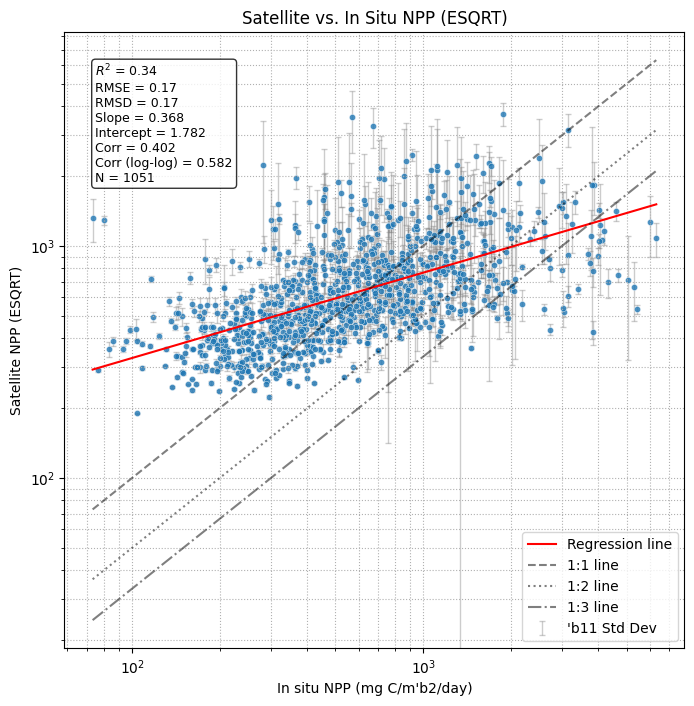

In [76]:
ds = npp.copy()

# 1. Access the CHL data variable
chl_data = ds['CHL_value_0']

# 2. Apply ESQRT model (NPP = 1000 * sqrt(CHL)) for every pixel at once
npp_cube = 1000 * np.sqrt(chl_data)

# 3. Average the n x n grids.
npp_mean = npp_cube.mean(dim=['y_grid', 'x_grid'])
npp_std = npp_cube.std(dim=['y_grid', 'x_grid'])

# 4. Add these results back into your dataset as new variables
ds['Satellite_NPP (ESQRT)'] = npp_mean
ds['Satellite_NPP_std (ESQRT)'] = npp_std

# 5. Select only the 1D result variables from Xarray
plot_df = ds[['Integrated_NPP', 'Satellite_NPP (ESQRT)', 'Satellite_NPP_std (ESQRT)']].to_dataframe()

# 7. Plot results
model_name = "ESQRT"
fig, ax = plt.subplots(figsize=(8, 8))
make_scatter_plot(plot_df, model_name, ax=ax)
plt.show()

## Vertically Generalized Production Model (VGPM)

In [ ]:
def vgpm(ds):
    # 1. Set up variables (ensuring strictly positive for logs/sqrt)
    chl = ds['CHL_value_0'].where(ds['CHL_value_0'] > 0)
    par = ds['PAR_value_0'].where(ds['PAR_value_0'] > 0)
    sst = ds['SST_value_0']

    # Handle Kelvin to Celsius conversion if needed
    if sst.mean() > 200:
        sst = sst - 273.15

    # 2. chl_tot and z_eu (Euphotic Depth)
    # Using xr.where(condition, if_true, if_false)
    chl_tot = xr.where(chl < 1.0, 38 * chl**0.425, 40.2 * chl**0.507)
    z_eu = 200.0 * chl_tot**(-0.293)
    z_eu = xr.where(z_eu <= 102.0, 568.2 * chl_tot**(-0.746), z_eu)

    # 3. pb_opt (The temperature-dependent optimal productivity)
    # This is the 7th-order polynomial from Behrenfeld & Falkowski (1997)
    pb_opt = (1.2956 + 0.2749 * sst + 0.0617 * sst**2 - 0.0205 * sst**3 + 
              0.002462 * sst**4 - 0.0001348 * sst**5 + 
              3.4132e-6 * sst**6 - 3.27e-8 * sst**7)

    # Apply temperature constraints
    pb_opt = xr.where(sst < 1.0, 1.13, pb_opt)
    pb_opt = xr.where(sst < -10.0, 0.0, pb_opt)
    pb_opt = xr.where(sst > 28.5, 4.0, pb_opt)

    # 4. Irradiance function
    irr_func = 0.66125 * par / (par + 4.1)

    # 5. Calculate NPP for each pixel
    npp_cube = pb_opt * chl * ds['day_length'] * irr_func * z_eu

    return npp_cube

# Run VGPM model
npp_cube = vgpm(ds)

# Average the n x n grids.
npp_mean = npp_cube.mean(dim=['y_grid', 'x_grid'])
npp_std = npp_cube.std(dim=['y_grid', 'x_grid'])

# Add these results back into your dataset as new variables
ds['Satellite_NPP (VGPM)'] = npp_mean
ds['Satellite_NPP_std (VGPM)'] = npp_std

# 5. Select only the 1D result variables from Xarray
plot_df = ds[['Integrated_NPP', 'Satellite_NPP (VGPM)', 'Satellite_NPP_std (VGPM)']].to_dataframe()

# 7. Plot results
model_name = "VGPM"
fig, ax = plt.subplots(figsize=(8, 8))
make_scatter_plot(plot_df, model_name, ax=ax)
plt.show()

## EDM

In [71]:
# Normalize satellite data for EDM

def quantile_transform(da, skip_vars, use_zscore=True):
    """
    Using a quantile transform because of extreme skewness in the satellite data.
    This transforms the data into a uniform distribution between [0,1] by ranking the values. 
    """
    
    if da.name in skip_vars or not np.issubdtype(da.dtype, np.number):
        return da

    vals = da.values.reshape(-1, 1)
    mask = np.isfinite(vals)
    clean_vals = vals[mask].reshape(-1, 1)

    # use Quantile Transform to force a uniform distribution
    qt = QuantileTransformer(output_distribution='uniform', n_quantiles=10000)
    transformed = qt.fit_transform(clean_vals)

    # 4. Reconstruct xarray
    res_vals = np.full_like(vals, np.nan)
    res_vals[mask] = transformed.flatten()
    
    return da.copy(data=res_vals.reshape(da.shape))

# List of variables to skip
skip_vars = ['Sta_ID', 'Date', 'regime', 'Latitude', 'Longitude', 'Integrated_NPP']
npp_norm = npp.map(quantile_transform, args=(skip_vars,))

/Users/deliacarpenter/miniconda3/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2846: UserWarning: n_quantiles (10000) is greater than the total number of samples (1265). n_quantiles is set to n_samples.
  warnings.warn(


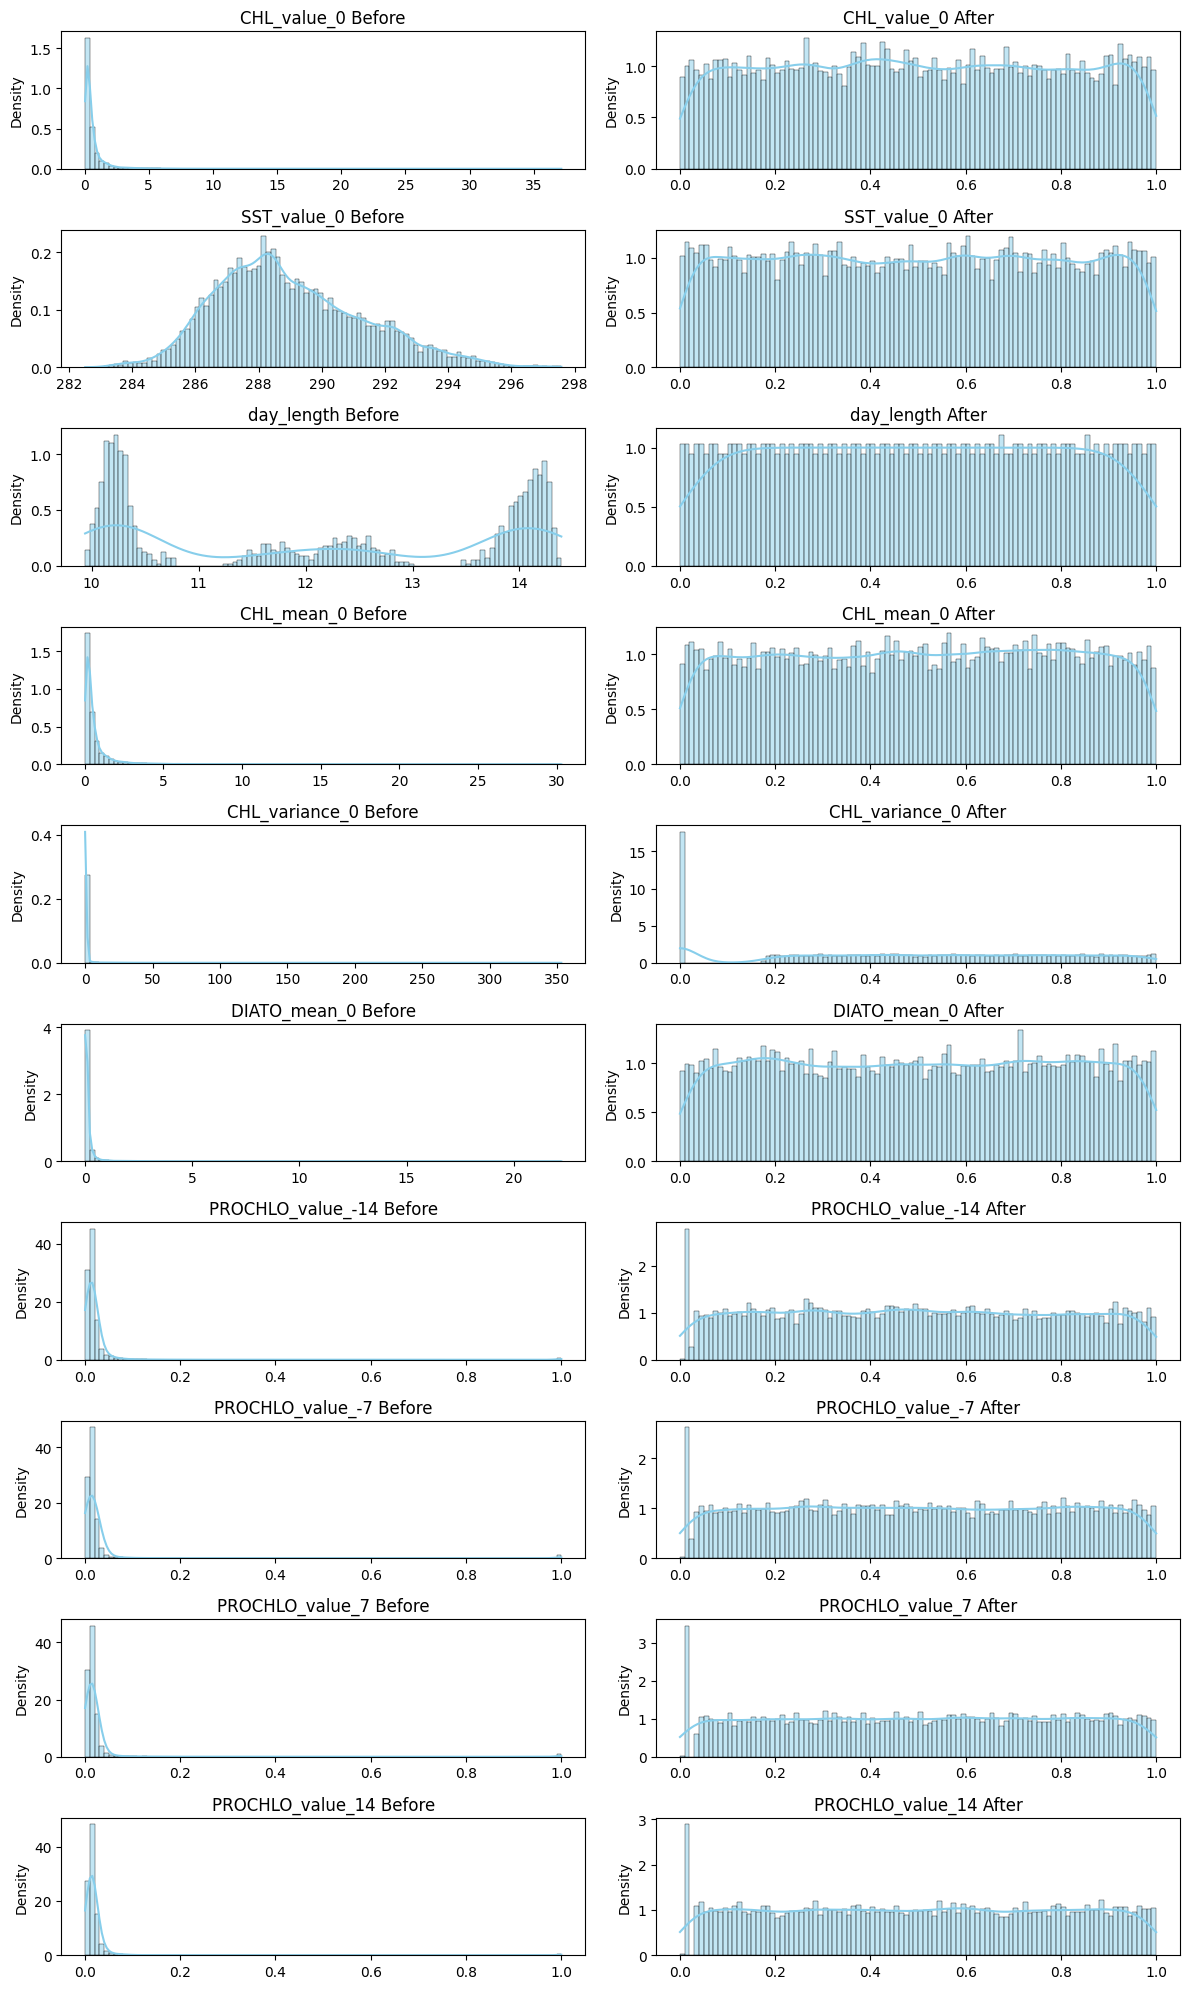

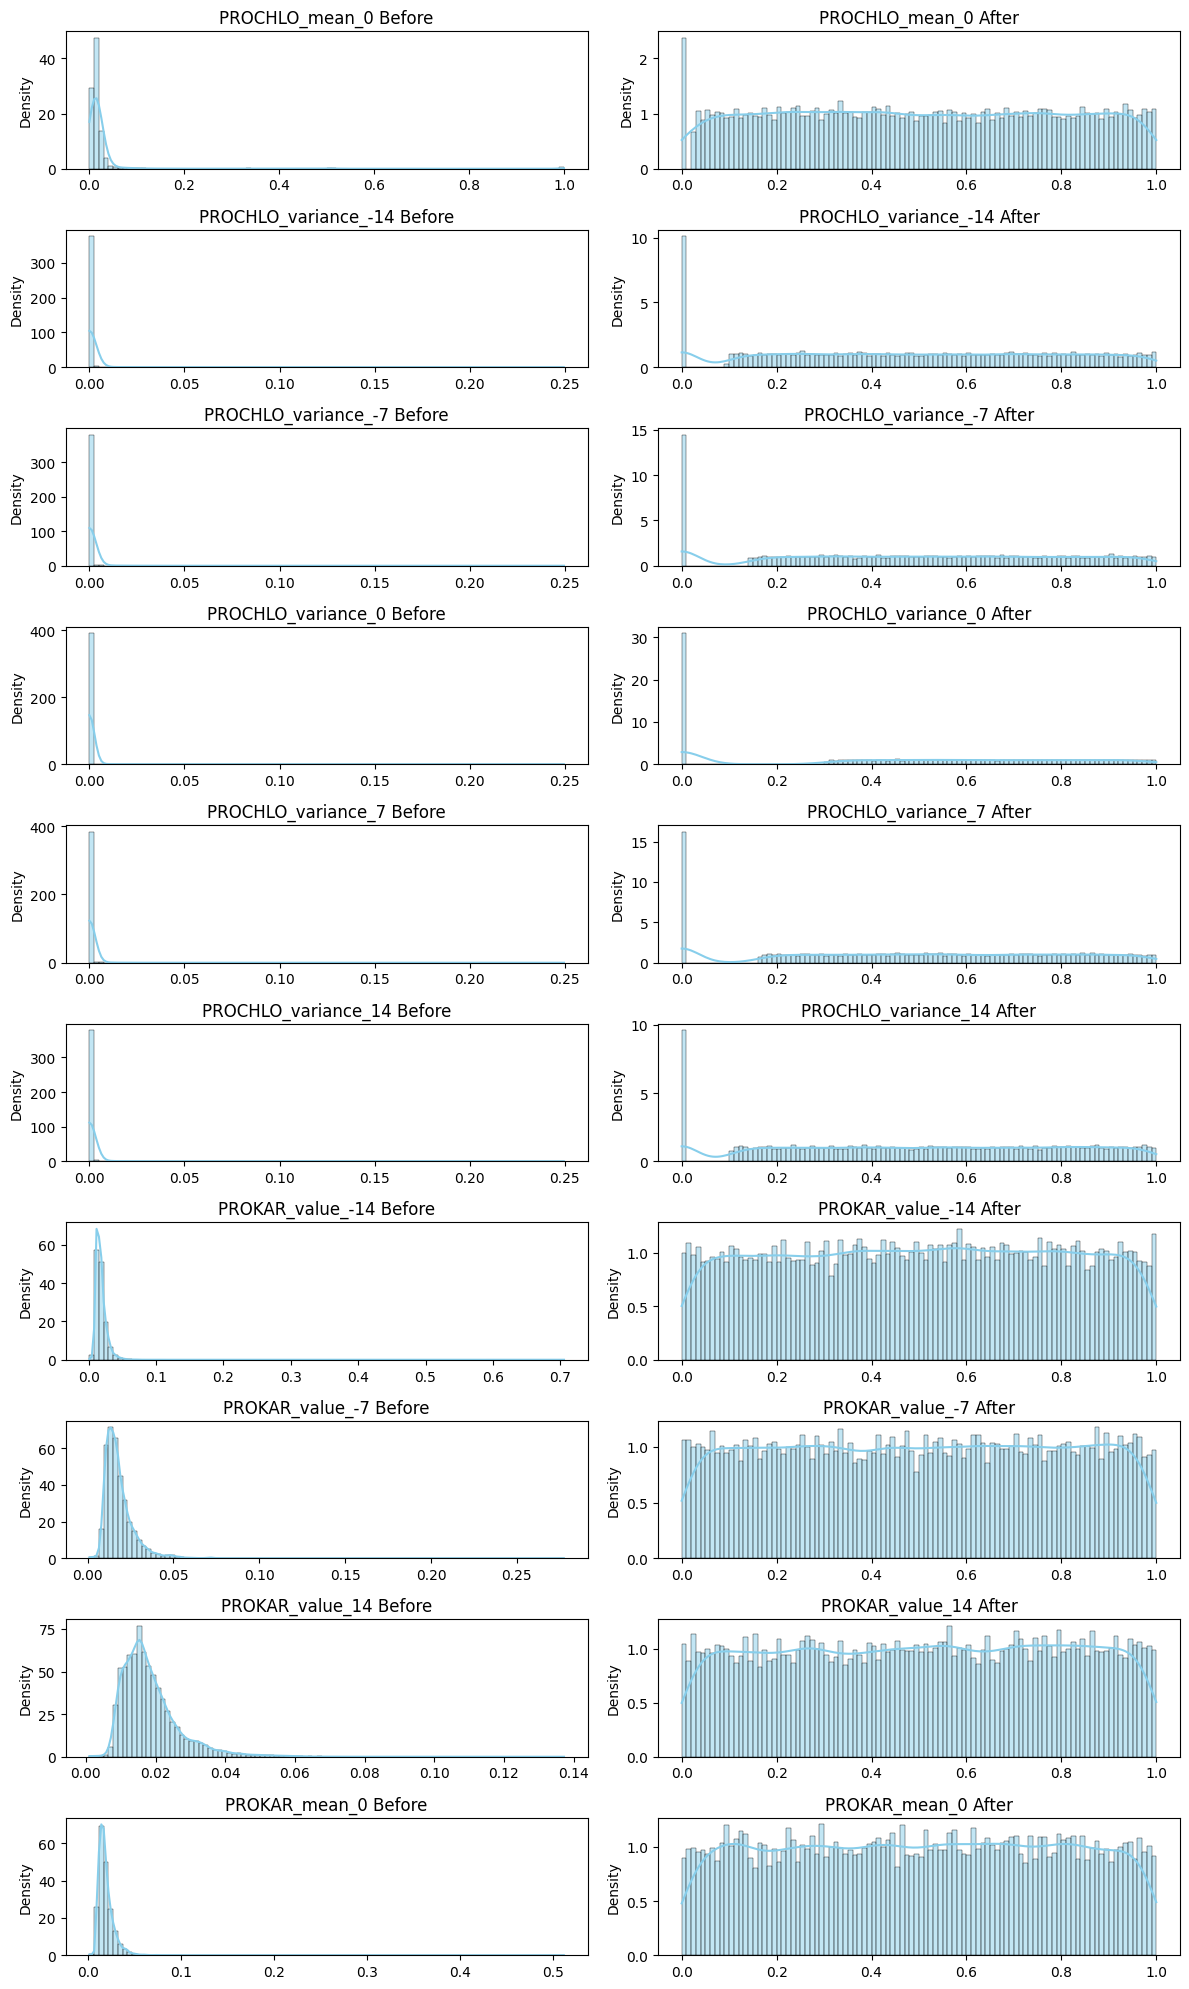

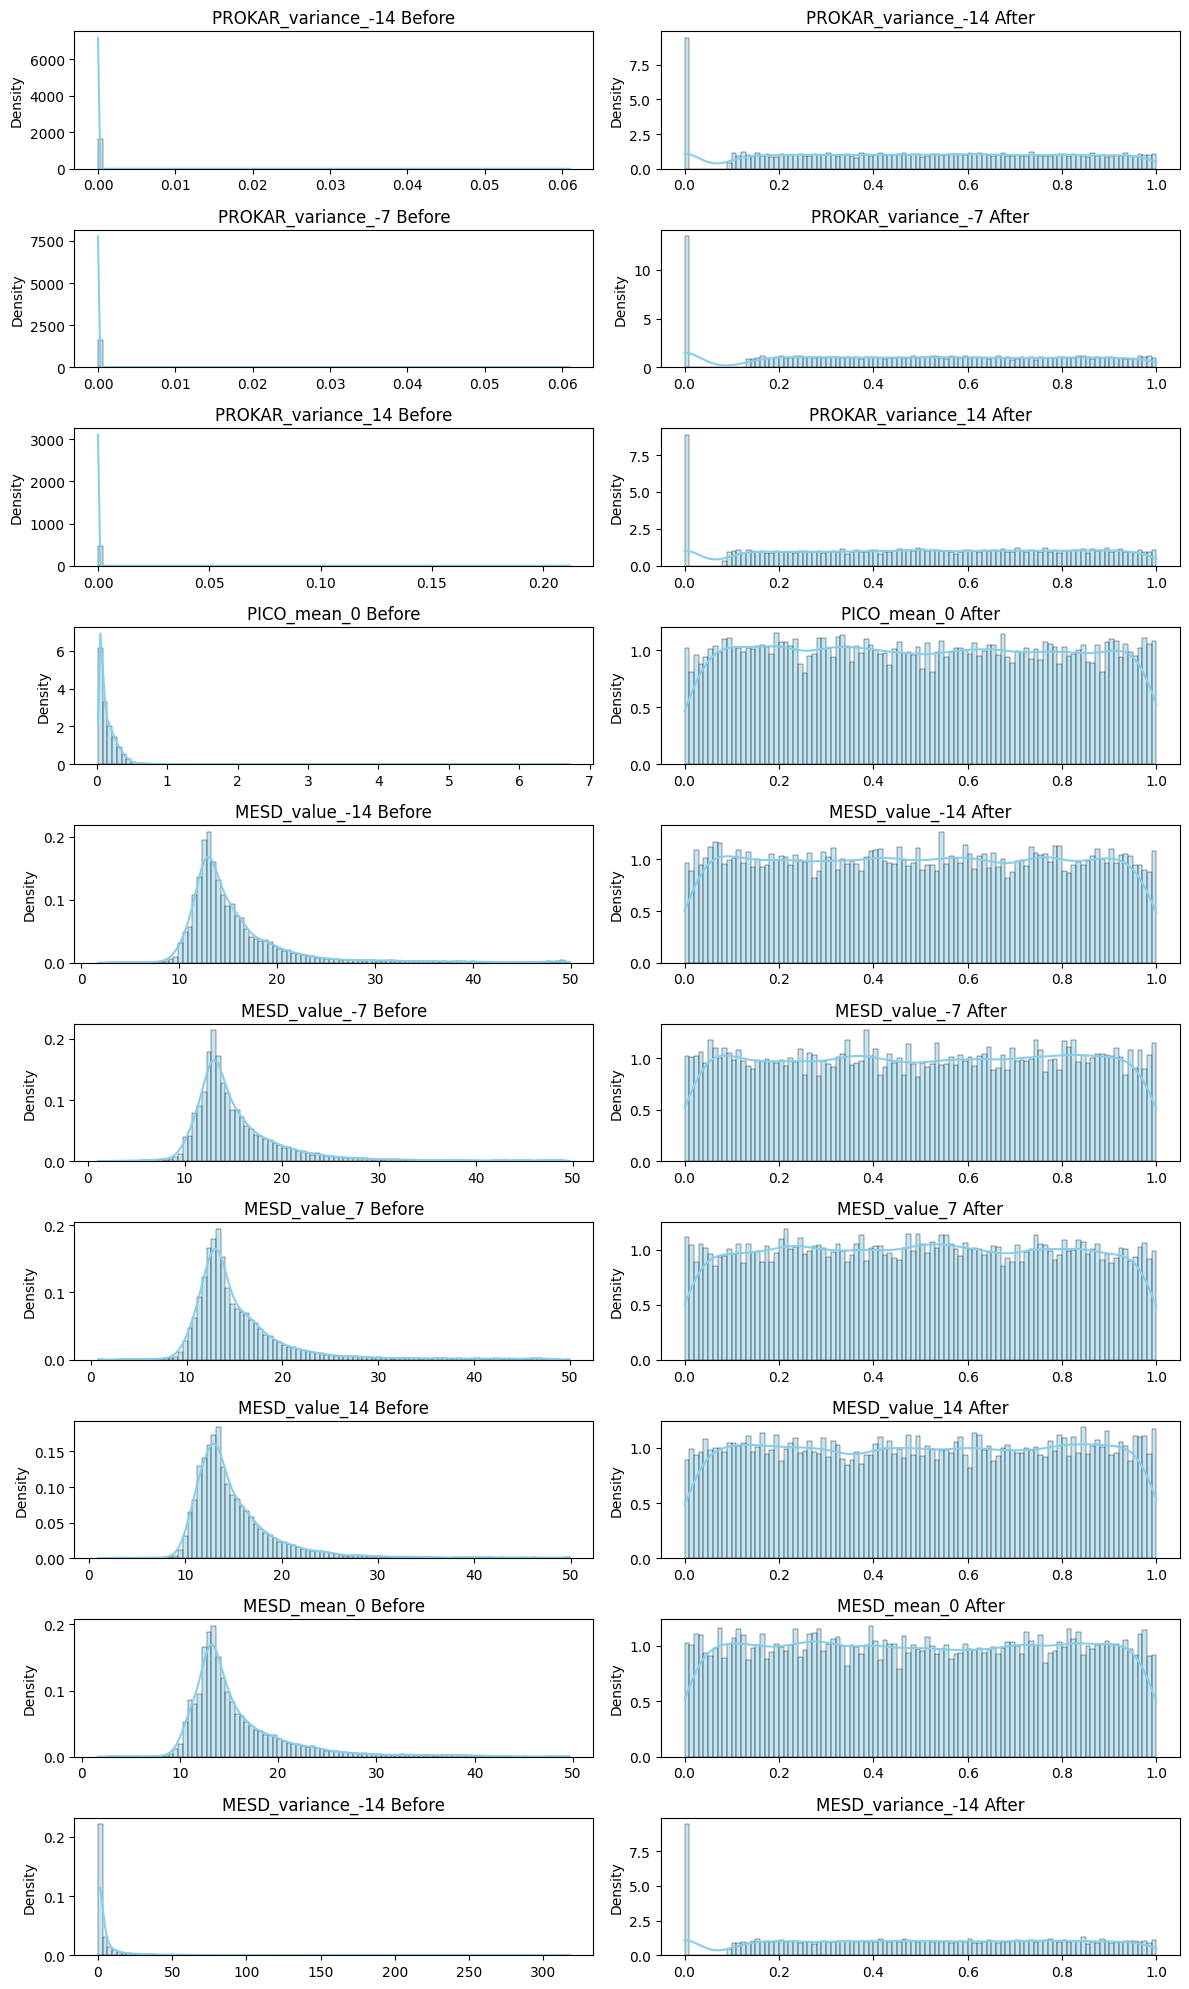

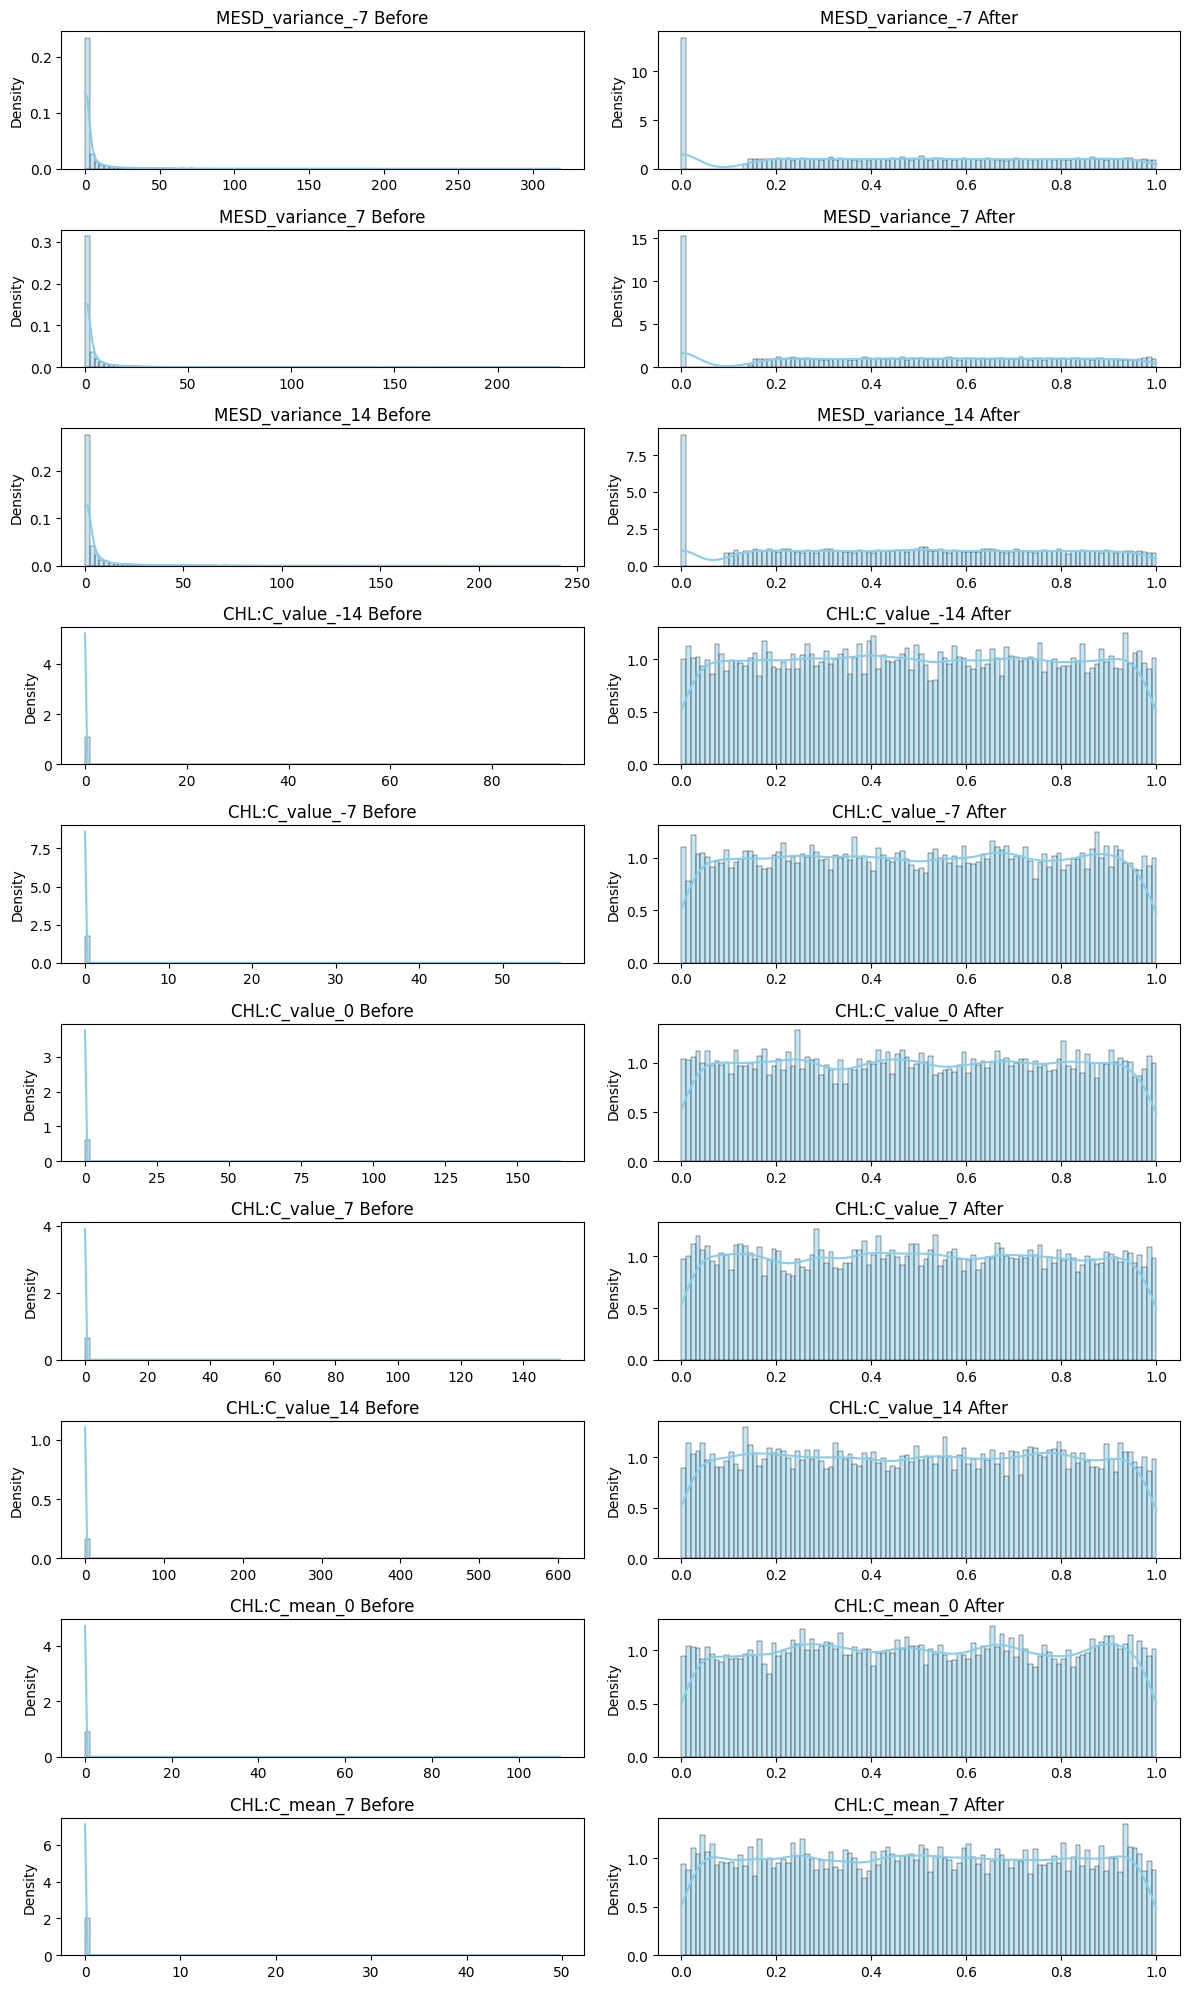

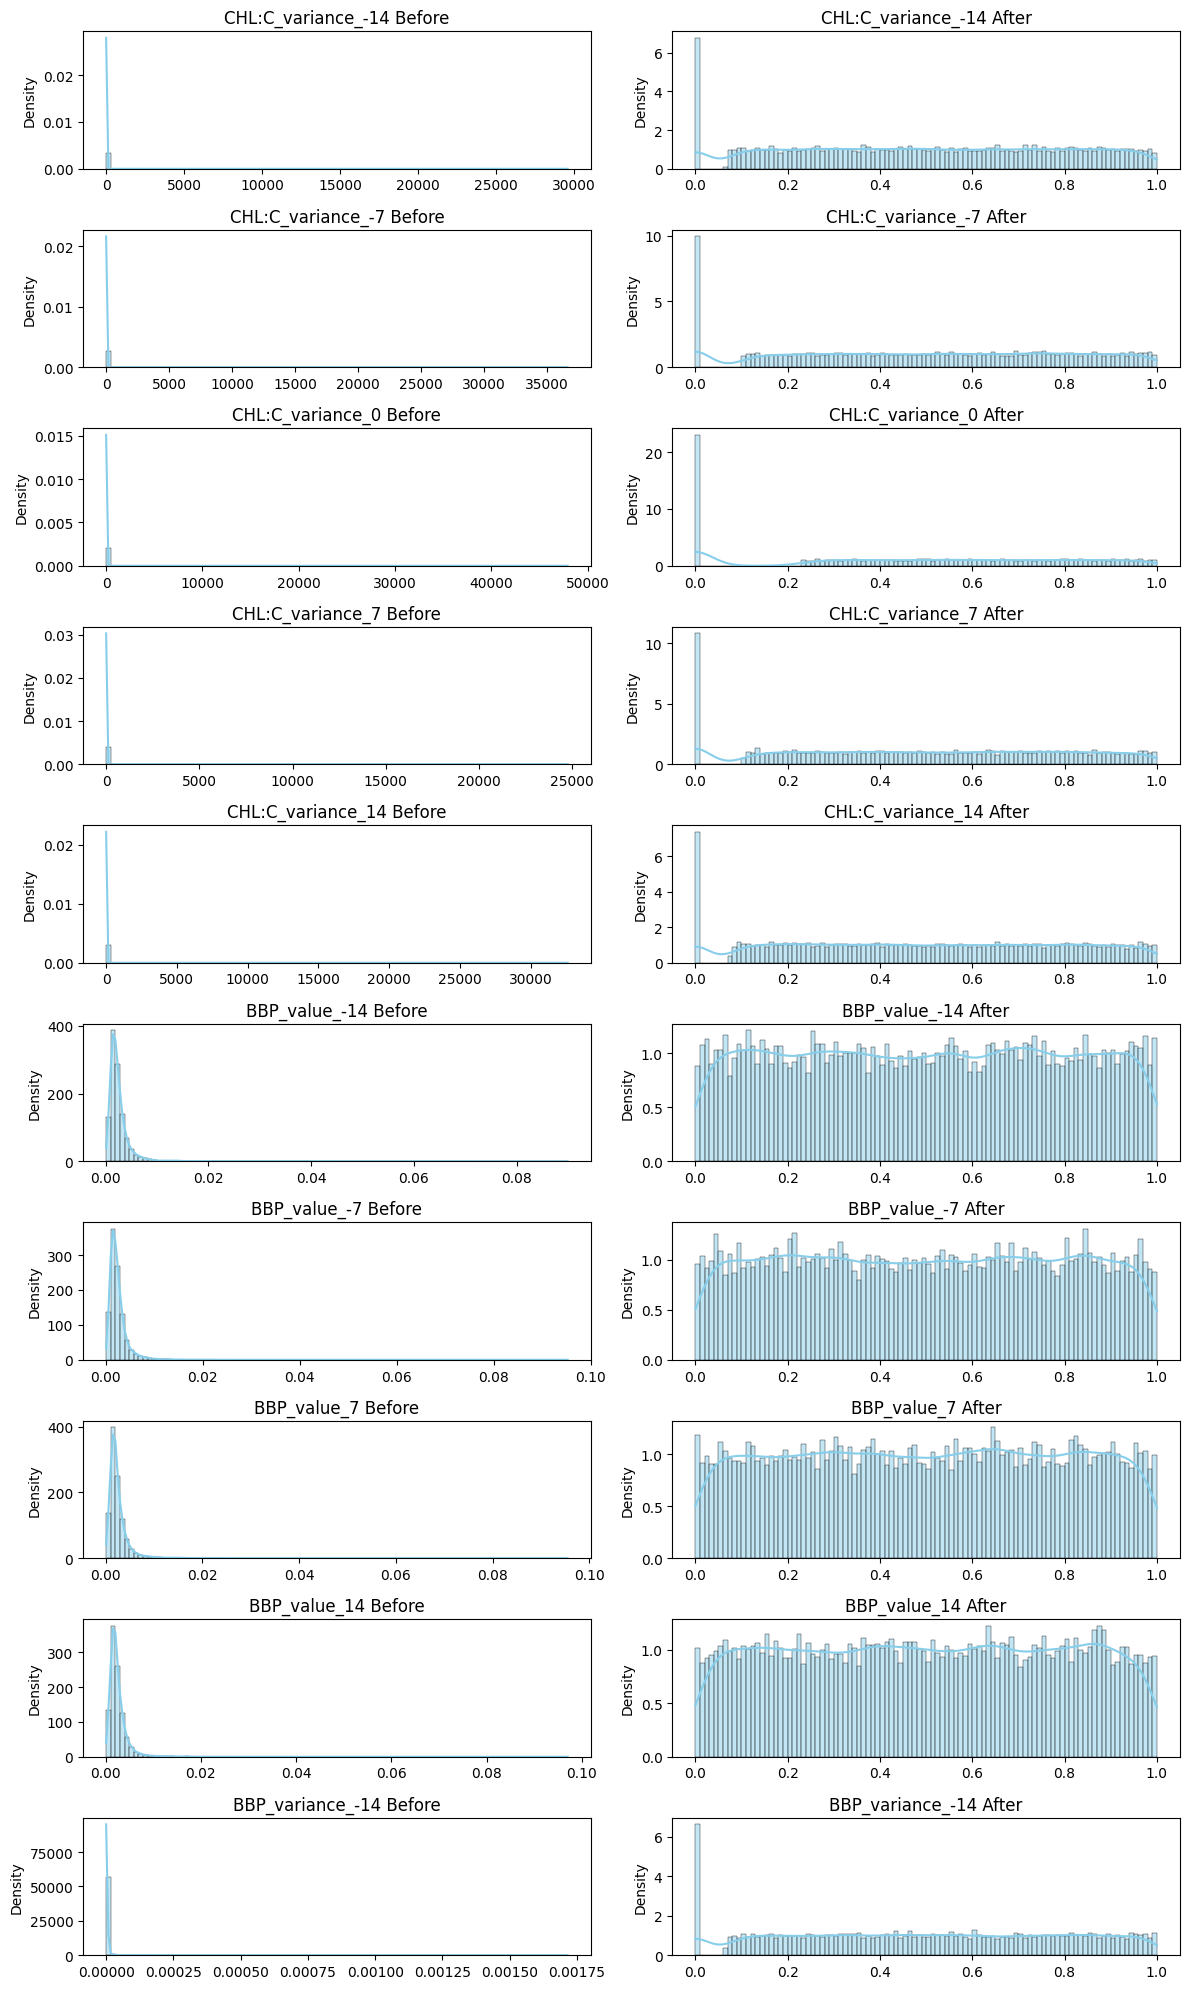

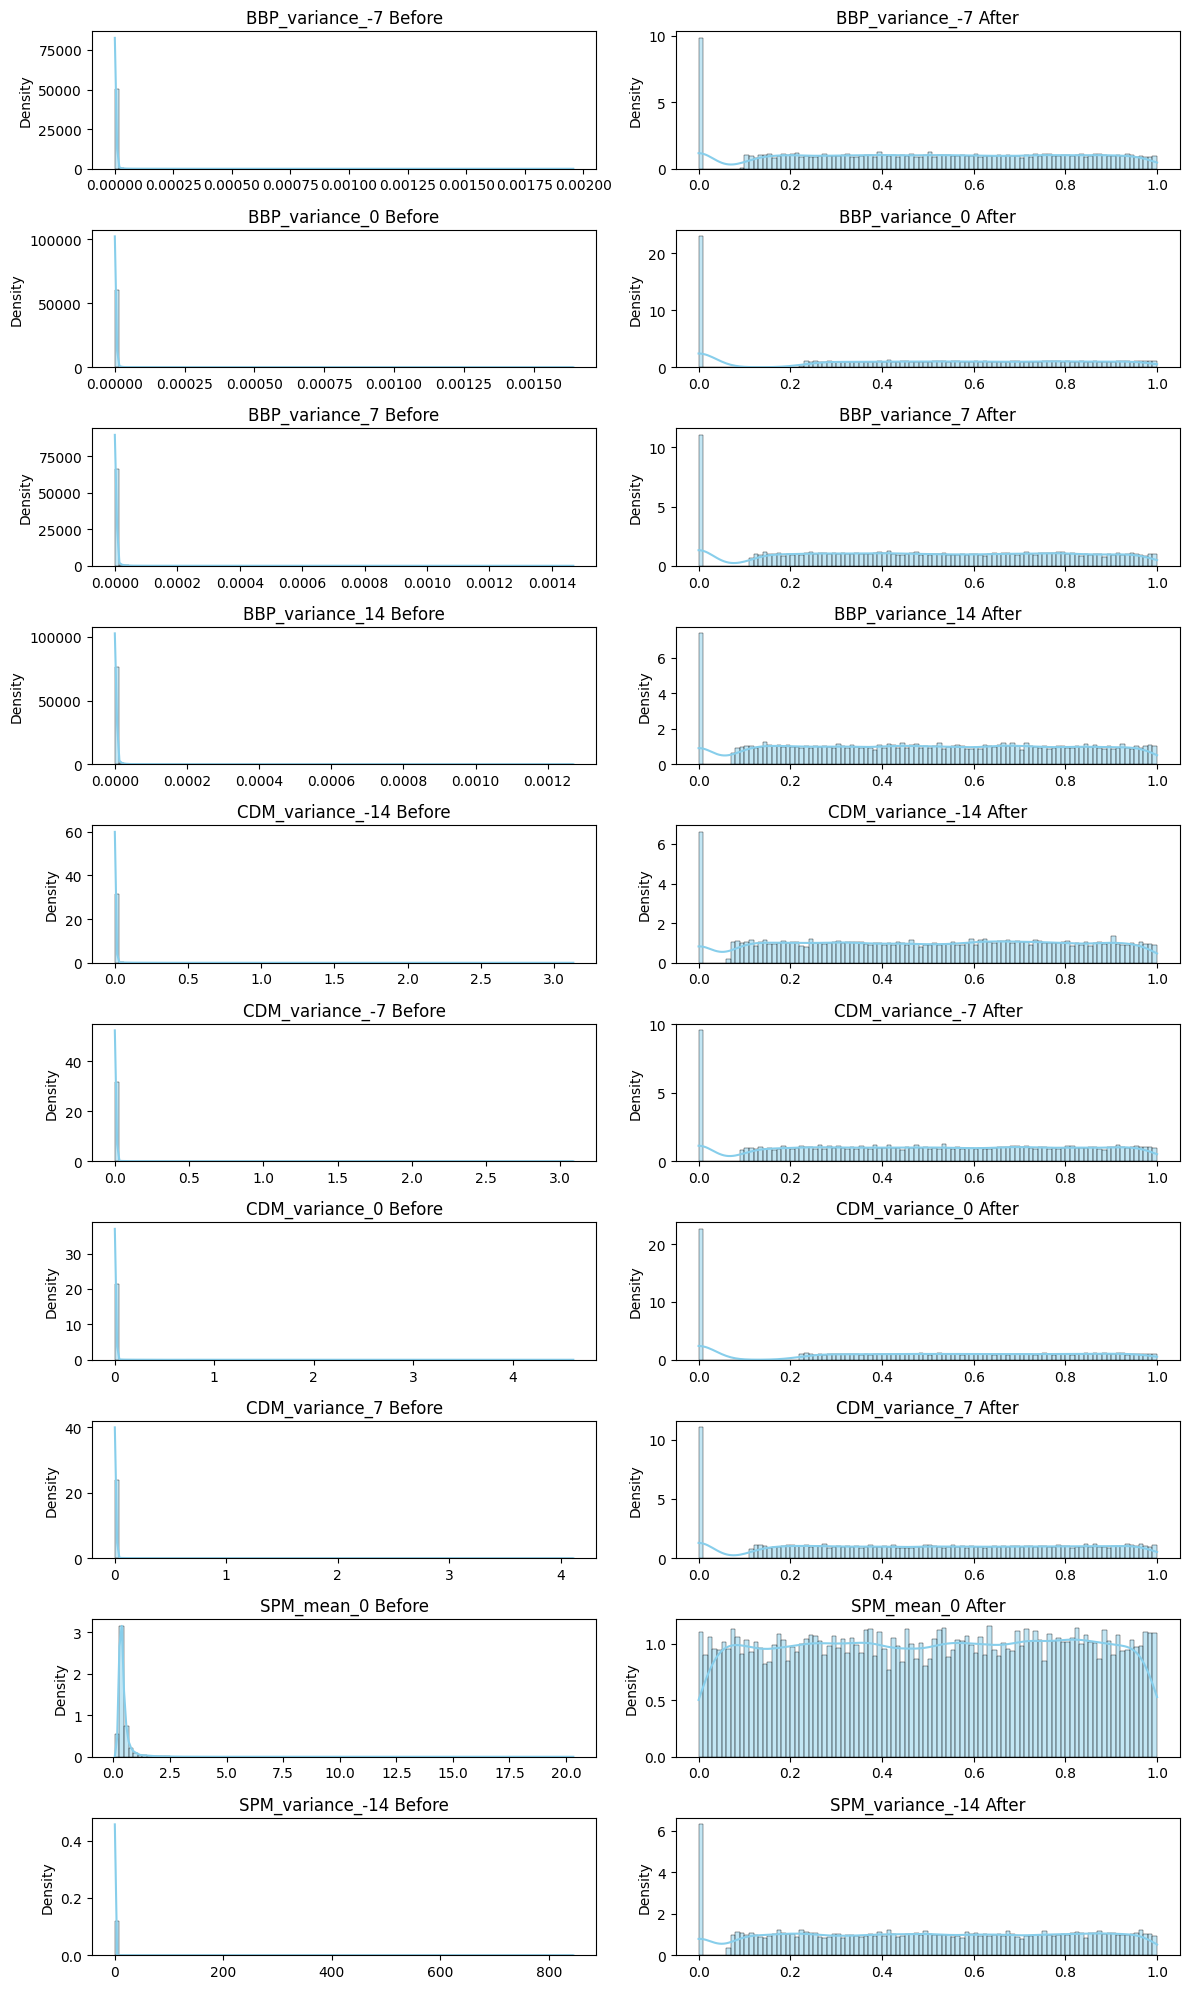

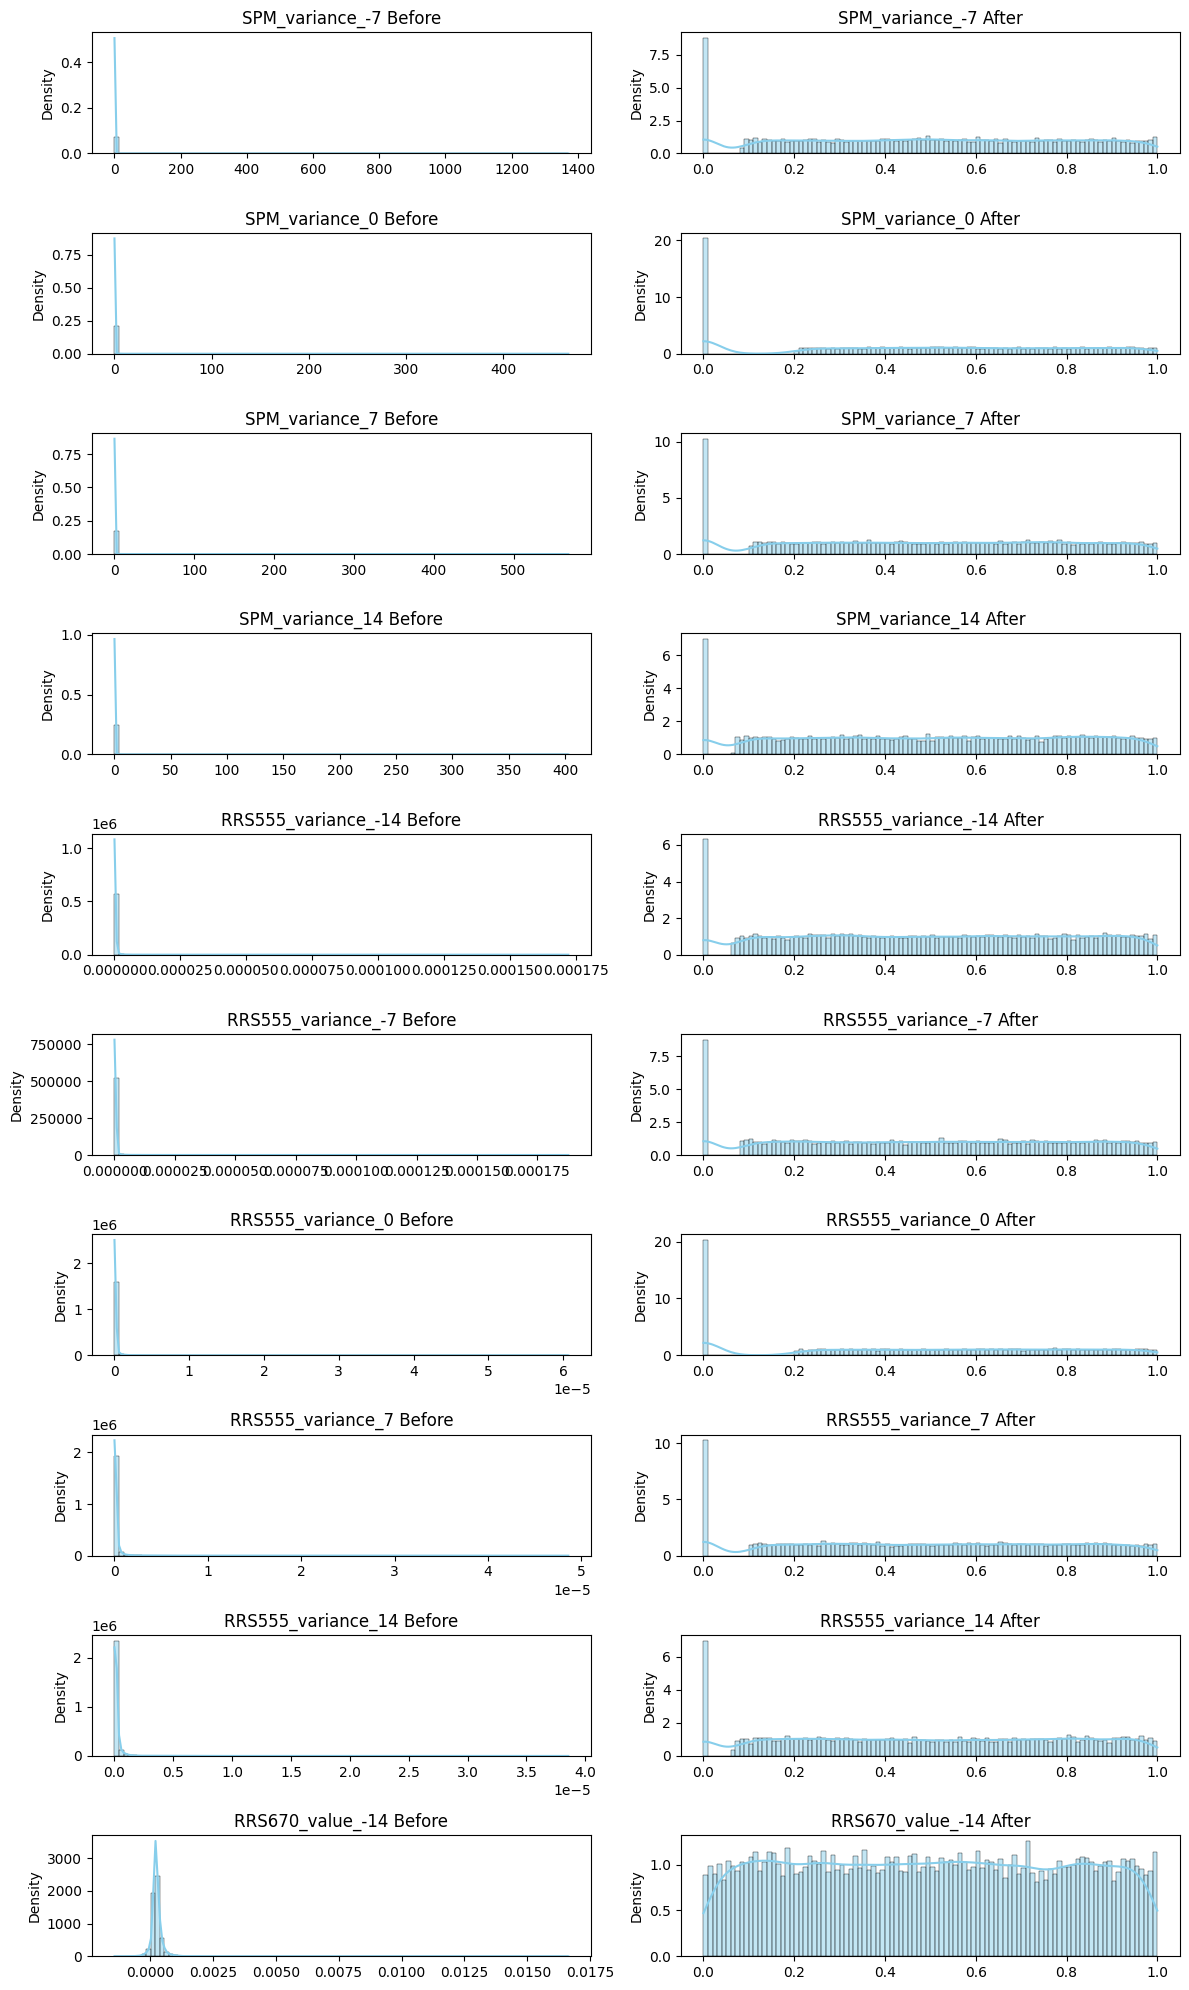

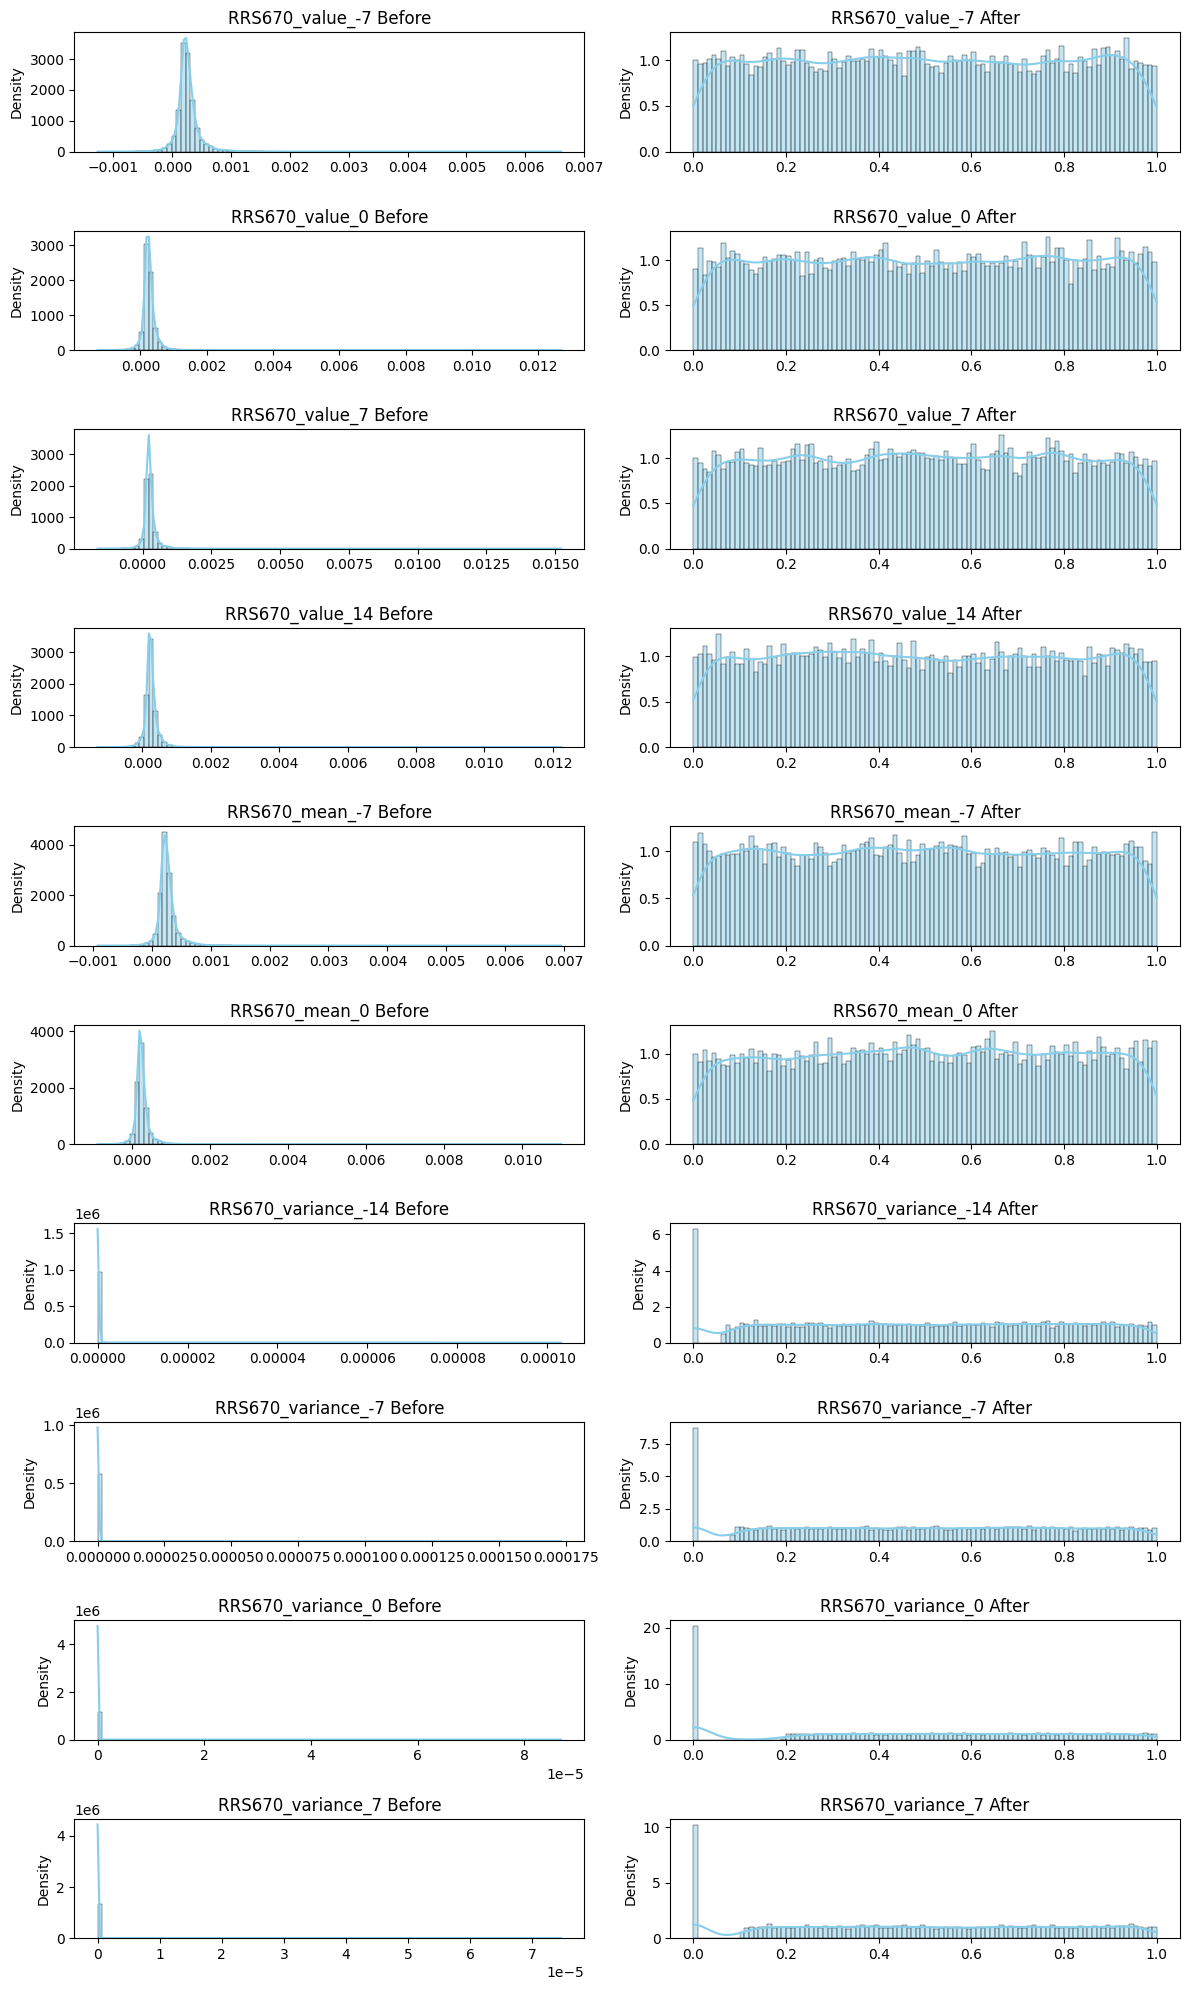

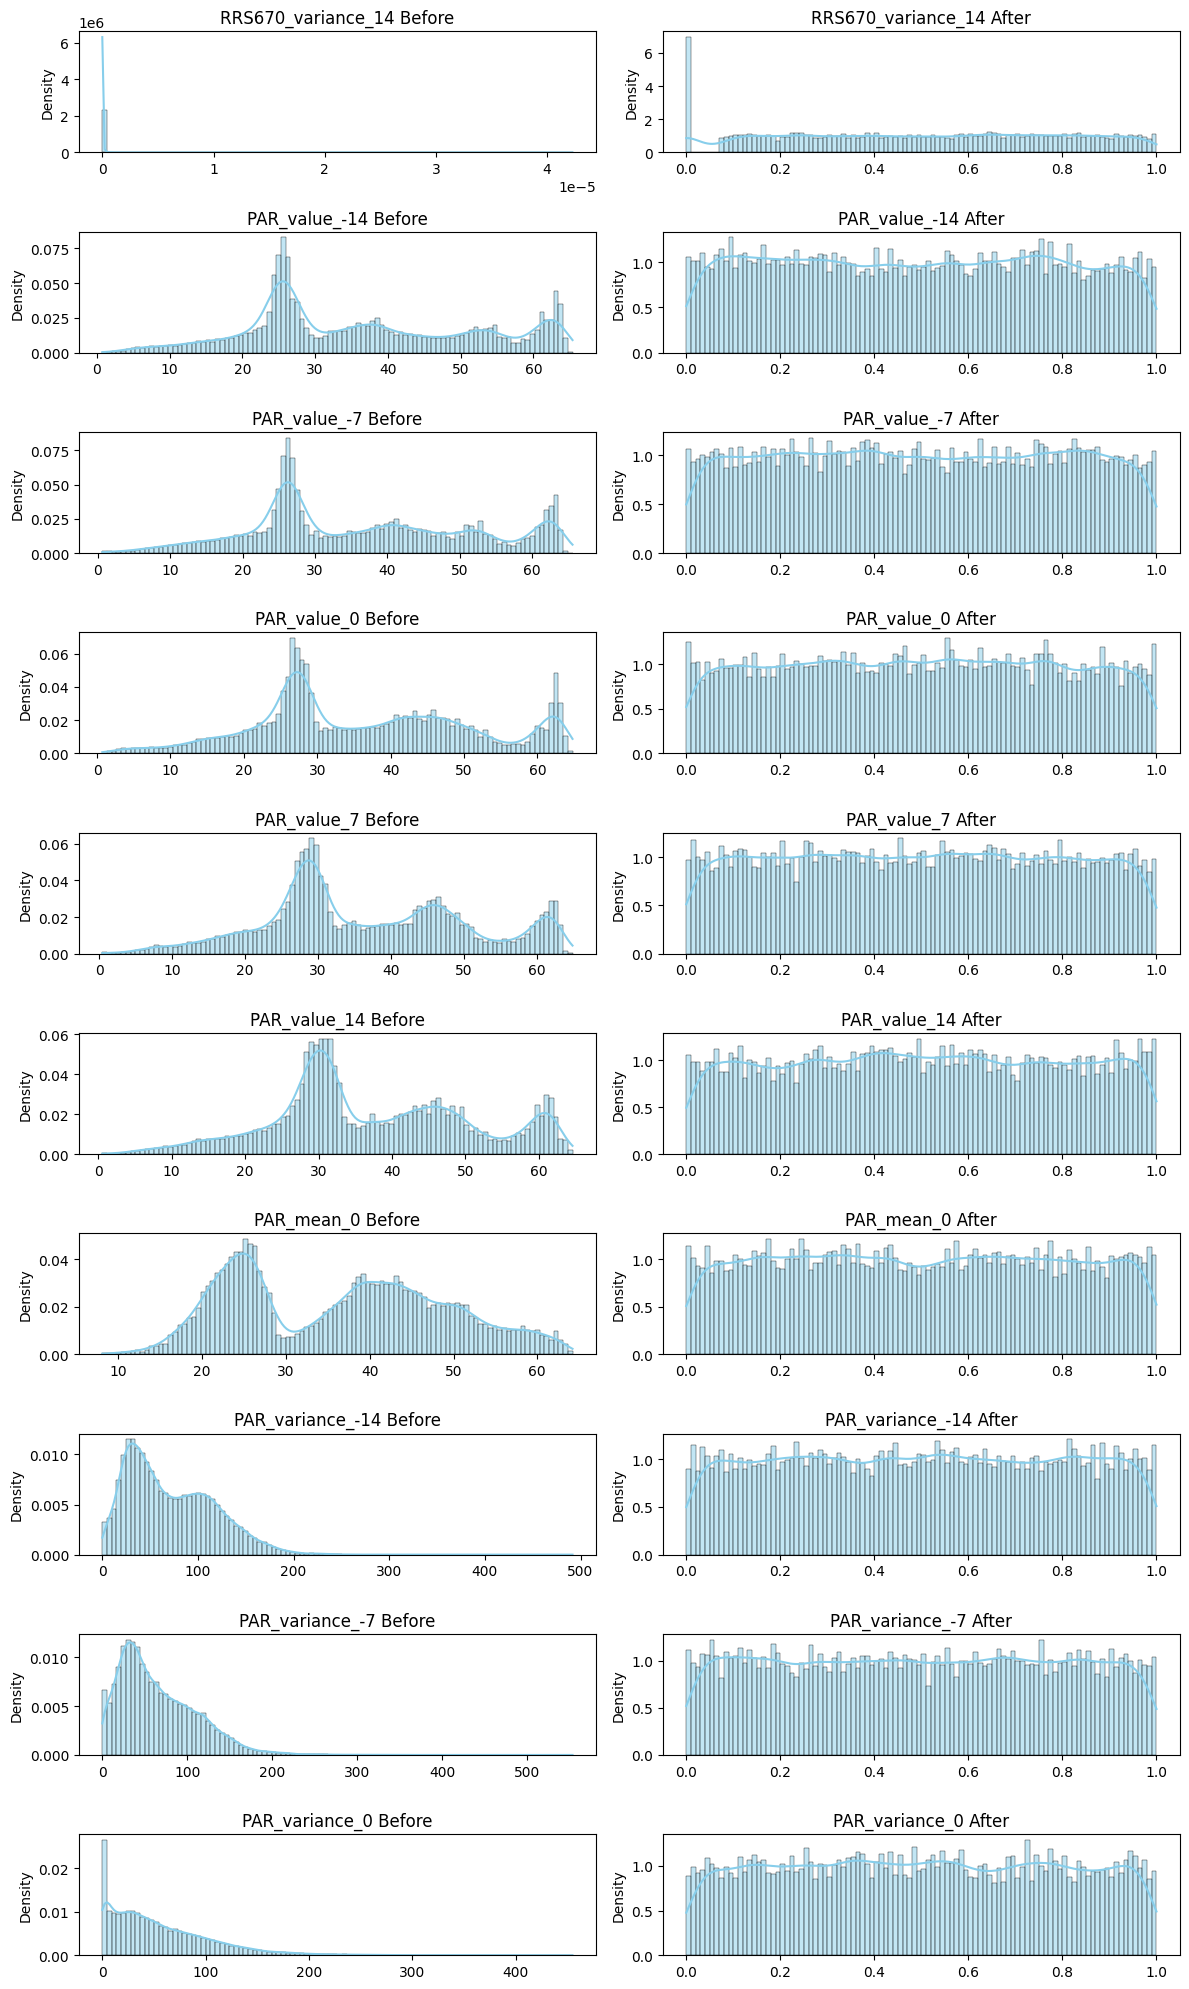

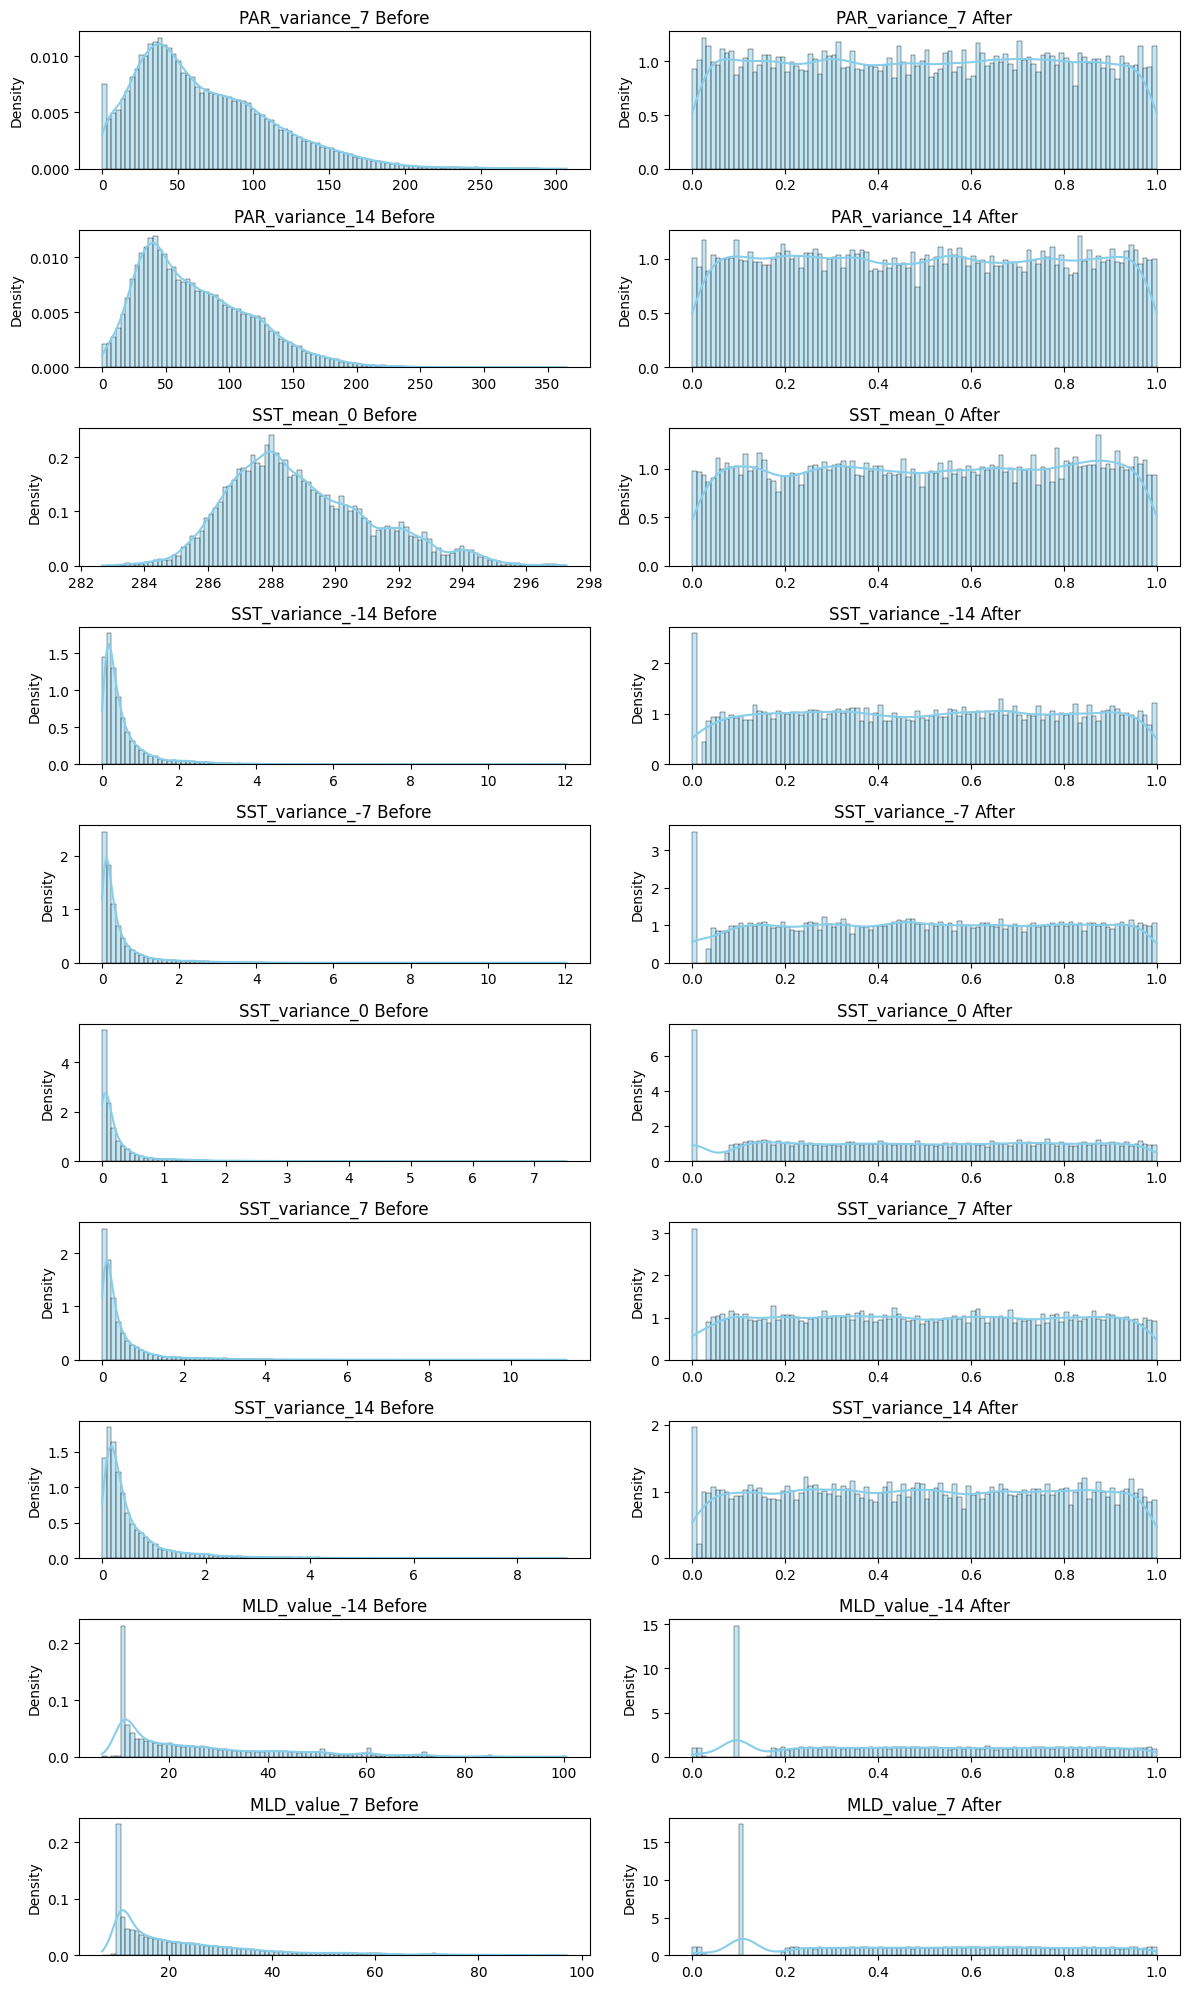

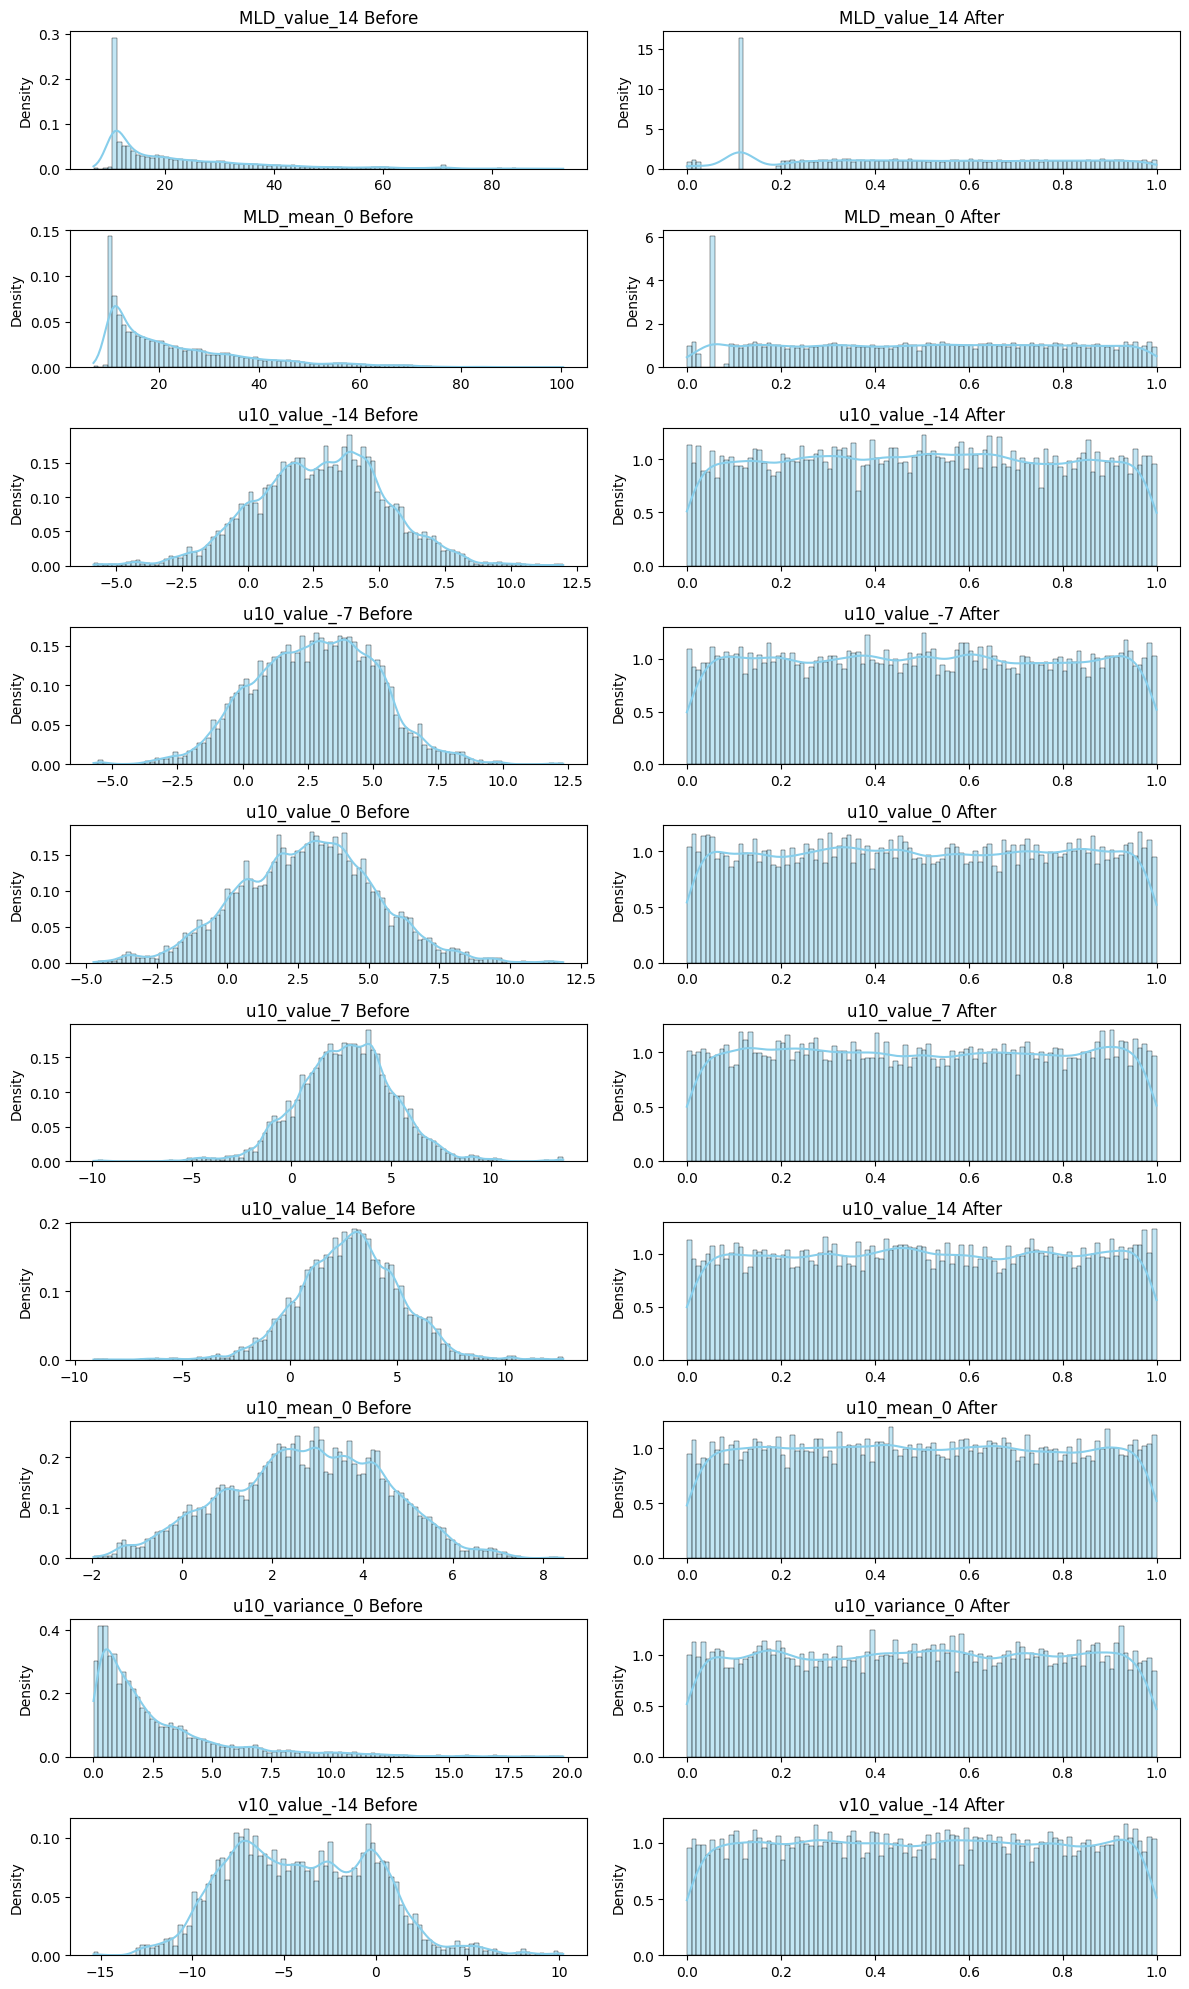

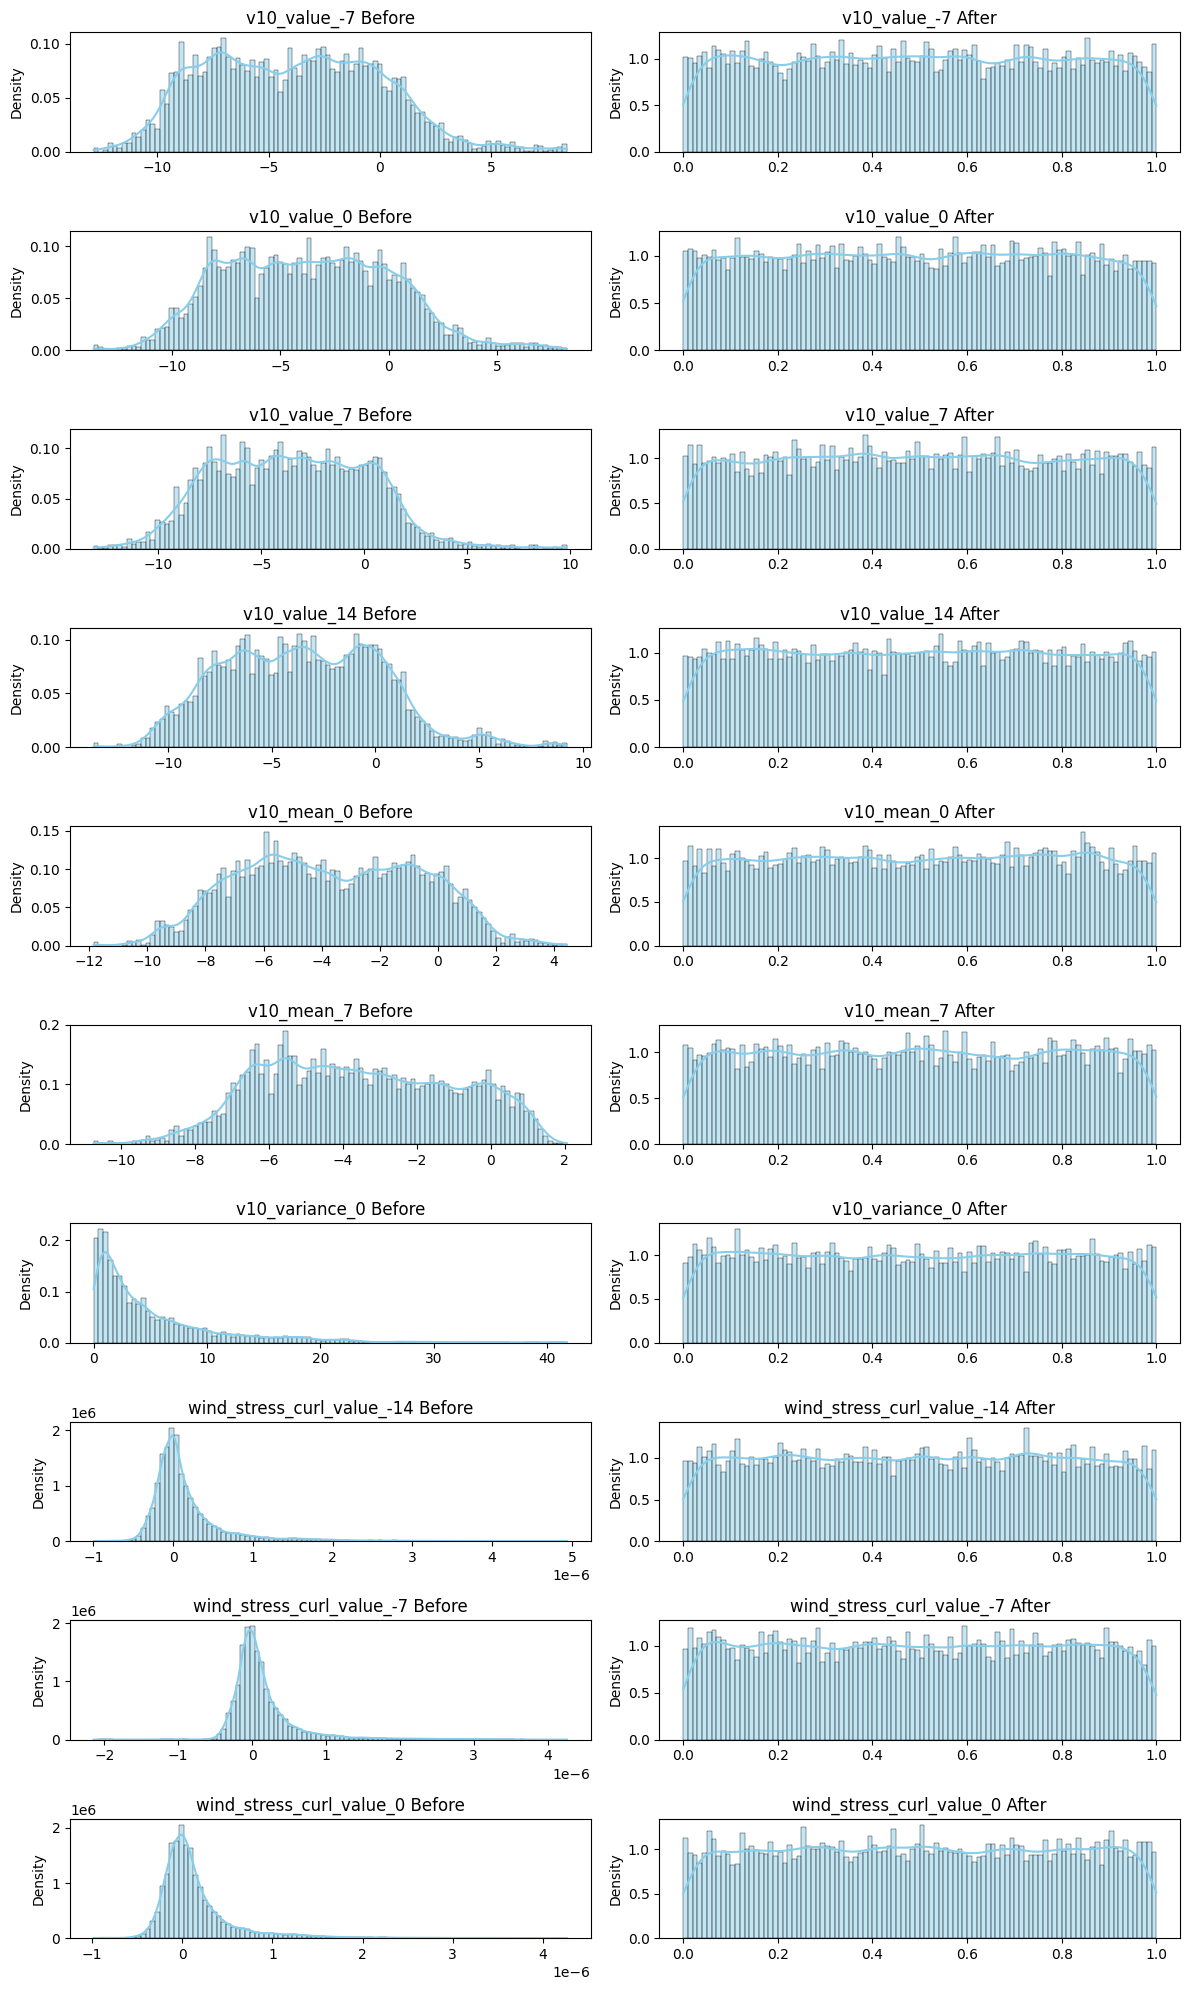

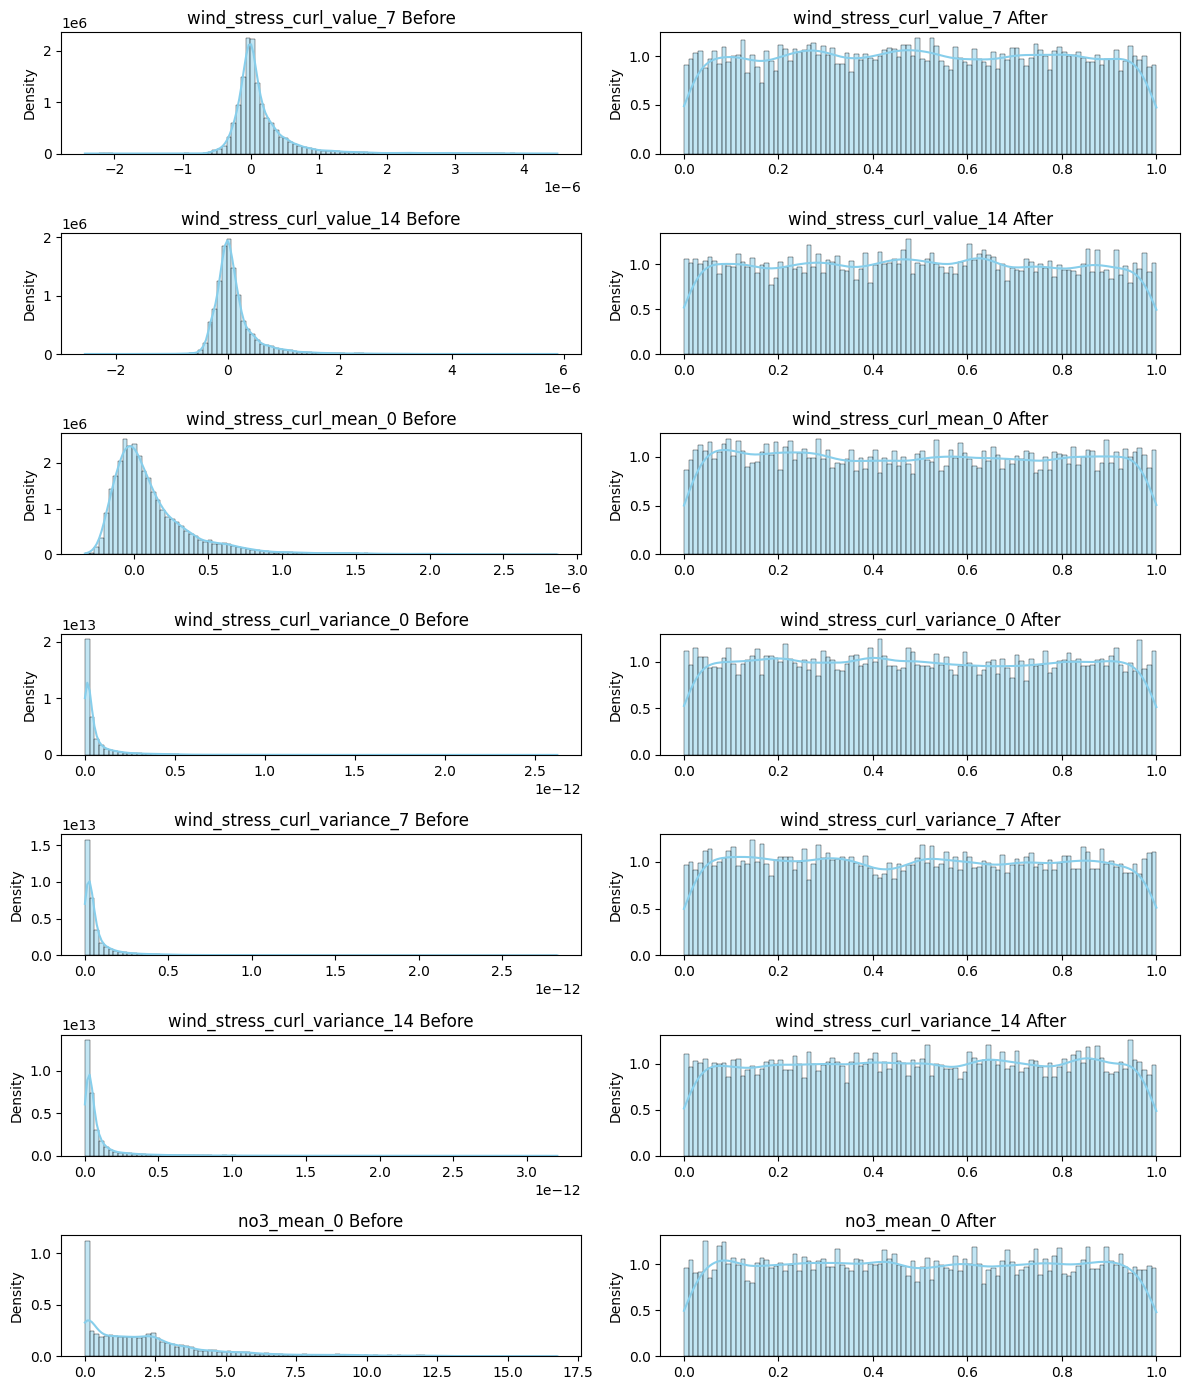

In [72]:
# Plot distributions before and after normalization
skip_vars = ['Sta_ID', 'Date', 'regime', 'Latitude', 'Longitude', 'Integrated_NPP']
plot_vars = [v for v in list(npp.data_vars) if v not in skip_vars]

# Plot in chunks of 10 variables to keep memory low
chunk_size = 10
for i in range(0, len(plot_vars), chunk_size):
    chunk = plot_vars[i:i+chunk_size]
    rows = len(chunk)
    fig, axes = plt.subplots(rows, 2, figsize=(12, rows*2))
    for idx, var in enumerate(chunk):
        var_raw = npp[var].values.flatten()
        var_norm = npp_norm[var].values.flatten()
        var_raw = var_raw[~np.isnan(var_raw)]
        var_norm = var_norm[~np.isnan(var_norm)]
        sns.histplot(var_raw, kde=True, color='skyblue', ax=axes[idx,0], stat='density', alpha=0.5, bins=100)
        sns.histplot(var_norm, kde=True, color='skyblue', ax=axes[idx,1], stat='density', alpha=0.5, bins=100)
        axes[idx,0].set_title(f'{var} Before')
        axes[idx,1].set_title(f'{var} After')
    plt.tight_layout()
    plt.show()
    plt.close(fig)

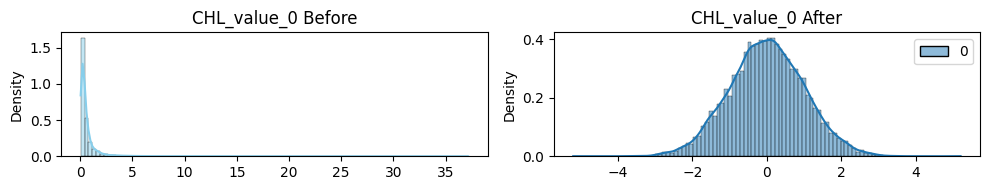

In [39]:
var = 'CHL_value_0'

fig, ax = plt.subplots(1,2, figsize=(10,2))
var_raw = npp[var].values.flatten()
var_log = npp[var].values.flatten()
var_log = np.log1p(var_log)

vals = var_raw.reshape(-1, 1)
mask = np.isfinite(vals)
clean_vals = vals[mask].reshape(-1, 1)
qt = QuantileTransformer(output_distribution='normal', n_quantiles=10000)
transformed = qt.fit_transform(clean_vals)

sns.histplot(var_raw, kde=True, color='skyblue', ax=ax[0], stat='density', alpha=0.5, bins=100)
sns.histplot(transformed, kde=True, color='skyblue', ax=ax[1], stat='density', alpha=0.5, bins=100)
ax[0].set_title(f'{var} Before')
ax[1].set_title(f'{var} After')
fig.tight_layout()
plt.show()

station_obs  y_grid  x_grid  v10_mean_0  u10_mean_0  Integrated_NPP  \
0                0       0       0    0.719972    0.033784       1105.2000   
1                0       0       1    0.730105    0.030072       1105.2000   
2                0       0       2    0.738548    0.026631       1105.2000   
3                0       0       3    0.746675    0.023602       1105.2000   
4                0       0       4    0.754046    0.020589       1105.2000   
...            ...     ...     ...         ...         ...             ...   
61980         1264       6       2    0.701067    0.077210       6323.9202   
61981         1264       6       3    0.708836    0.066170       6323.9202   
61982         1264       6       4    0.716348    0.058405       6323.9202   
61983         1264       6       5    0.723147    0.051939       6323.9202   
61984         1264       6       6    0.731534    0.044526       6323.9202   

            Sta_ID       Date  
0      093.3 026.7 1997-12-29  
1      093.3 026.7 1997-12-29  
2      093.3 026.7 1997-12-29  
3      093.3 026.7 1997-12-29  
4      093.3 026.7 1997-12-29  
...            ...        ...  
61980  076.7 049.0 2020-01-22  
61981  076.7 049.0 2020-01-22  
61982  076.7 049.0 2020-01-22  
61983  076.7 049.0 2020-01-22  
61984  076.7 049.0 2020-01-22  

[61985 rows x 8 columns]

Text(0.5, 1.0, 'State-Space Reconstruction using Satellite Variables')

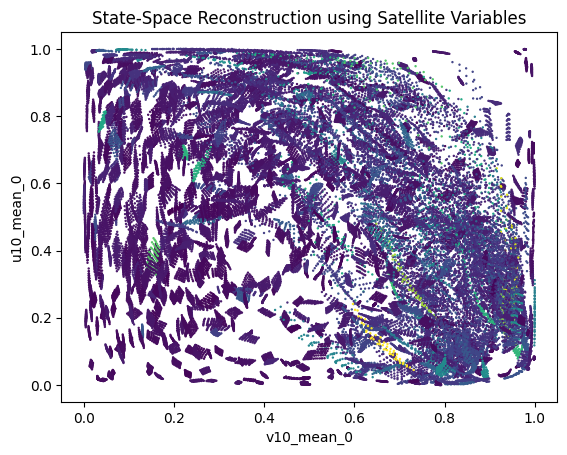

In [88]:
# 1. Extract values from xarray
embedding_cols = ['v10_mean_0', 'u10_mean_0']
target = 'Integrated_NPP'

df = npp_norm[embedding_cols + [target]].to_dataframe().reset_index()
display(df)

# Visualize state-space reconstruction
fig, ax = plt.subplots()
ax.scatter(df[embedding_cols[0]], df[embedding_cols[1]], s=0.5, c=df[target], cmap='viridis')
ax.set_xlabel(embedding_cols[0])
ax.set_ylabel(embedding_cols[1])
ax.set_title('State-Space Reconstruction using Satellite Variables')

In [96]:
to_edm = df[embedding_cols+[target]]

# Cross-map to target (NPP)
xmap = Simplex(dataFrame=to_edm,
               target=target,
               columns=embedding_cols,
               embedded=True,
               lib=f'1 {len(to_edm)}',
               pred=f'1 {len(to_edm)}',
               Tp = 0,
               noTime=True,
               returnObject=True
)
# xmap = xmap[['Observations', 'Predictions']]
# fig, ax = plt.subplots()
# ax.scatter(xmap['Observations'], xmap['Predictions'], s=1)
# plt.xscale('log')
# plt.yscale('log')

# Query the kdTree for the top 55 neighbors for each point

query_data = to_edm[embedding_cols].dropna()

K_SEARCH = 55
distances, indices = xmap.kdTree.query(query_data, k=K_SEARCH)
indices

v10_mean_0  u10_mean_0
0        0.719972    0.033784
1        0.730105    0.030072
2        0.738548    0.026631
3        0.746675    0.023602
4        0.754046    0.020589
...           ...         ...
61980    0.701067    0.077210
61981    0.708836    0.066170
61982    0.716348    0.058405
61983    0.723147    0.051939
61984    0.731534    0.044526

[61985 rows x 2 columns]

array([[    0, 44678, 44679, ..., 44666, 44675, 61983],
       [    1, 44419, 44420, ..., 15447, 38316, 44399],
       [    2, 44425, 44426, ...,    22, 44442, 44687],
       ...,
       [61982, 49585, 49586, ..., 15331, 44398, 44670],
       [61983, 44403, 44409, ..., 44417, 44406, 49572],
       [61984, 44416, 44677, ..., 32287, 32280, 44415]])

In [98]:
embedding_cols = ['day_length', 'v10_mean_0'] #['wind_stress_curl_mean_0', 'wind_stress_curl_variance_14']
target = 'Integrated_NPP'

df_stacked = npp_norm[embedding_cols + [target]].to_dataframe().reset_index()

to_edm = df_stacked[[target] + embedding_cols]
to_edm.insert(0, 'Time', to_edm.index+1)
lib = f'1 {len(to_edm)}'
pred = f'1 {len(to_edm)}'

xmap_obj = Simplex(dataFrame=to_edm,
               columns=embedding_cols,
               target=target,
               lib=lib,
               pred=pred,
               Tp=0,
               embedded=True,
              )

In [101]:
# --- EDM SECTION: STEP 1 (Manifold Reconstruction) ---

## Cross-mapping (manual out-of-sample check)

# Choose embedding columns for state-space reconstruction
embedding_cols = ['wind_stress_curl_mean_0', 'wind_stress_curl_variance_14']
target = 'Integrated_NPP'

# Flatten the 3D array (station_obs, y_grid, x_grid) into a 2D "stacked" table for the EDM library. 
# We will be using every available pixel as our library set (excluding pixels that belong to the same NPP observation)
df_stacked = npp[embedding_cols + [target]].to_dataframe().reset_index()


# df_stacked = npp_norm[embedding_cols + [target]].to_dataframe().reset_index()
to_edm = df_stacked[[target] + embedding_cols]
to_edm.insert(0, 'Time', to_edm.index+1)
lib = f'1 {len(to_edm)}'
pred = f'1 {len(to_edm)}'

# Get cross-map estimates
xmap_obj = Simplex(dataFrame=to_edm,
               columns=embedding_cols,
               target=target,
               lib=lib,
               pred=pred,
               Tp=0,
               embedded=True,
               returnObject=True
              )

# 1. Identify which rows are actually valid for the query
# (No NaNs in the embedding columns)
valid_query_mask = to_edm[embedding_cols].notna().all(axis=1)
valid_query_indices = np.where(valid_query_mask)[0]
query_data = to_edm.iloc[valid_query_indices][embedding_cols].values

# Query the kdTree for the top 55 neighbors for each point
K_SEARCH = 55
distances, indices = xmap_obj.kdTree.query(query_data, k=K_SEARCH)

# 3. Setup containers for the full dataset (size N)
n_total = len(to_edm)
final_predictions = np.full(n_total, np.nan)
target_values = to_edm[target].values
sta_ids = df_stacked['station_obs'].values

# 4. Perform the Simplex math ONLY on the valid points
E = len(embedding_cols)

# We iterate over the results of the query (which match valid_query_indices)
for i, original_idx in enumerate(valid_query_indices):
    
    # Get neighbors for this specific valid point
    neighbor_indices = indices[i]
    neighbor_dists = distances[i]
    
    # Check for "Illegal" neighbors (same station_obs)
    p_sta = sta_ids[original_idx]
    n_stas = sta_ids[neighbor_indices]
    
    is_legal = (n_stas != p_sta)
    
    # Grab the first E+1 legal neighbors
    legal_idx = neighbor_indices[is_legal][:E+1]
    legal_dist = neighbor_dists[is_legal][:E+1]
    
    if len(legal_idx) < E+1:
        continue # Skip if we can't find enough neighbors outside the station
        
    # Weighted Simplex Math
    min_dist = legal_dist[0]
    if min_dist > 0:
        weights = np.exp(-legal_dist / min_dist)
    else:
        weights = np.zeros(len(legal_dist))
        weights[legal_dist == 0] = 1.0
        
    weights /= np.sum(weights)
    
    # Store prediction
    final_predictions[original_idx] = np.dot(weights, target_values[legal_idx])

df_stacked['Predictions'] = final_predictions
xmap = df_stacked
xmap

station_obs  y_grid  x_grid  wind_stress_curl_mean_0  \
0                0       0       0             1.091754e-07   
1                0       0       1             9.618060e-08   
2                0       0       2             8.318823e-08   
3                0       0       3             7.019586e-08   
4                0       0       4             5.720110e-08   
...            ...     ...     ...                      ...   
61980         1264       6       2             4.012415e-07   
61981         1264       6       3             3.703609e-07   
61982         1264       6       4             3.393932e-07   
61983         1264       6       5             3.084235e-07   
61984         1264       6       6             2.774482e-07   

       wind_stress_curl_variance_14  Integrated_NPP       Sta_ID       Date  \
0                      4.417659e-14       1105.2000  093.3 026.7 1997-12-29   
1                      4.075981e-14       1105.2000  093.3 026.7 1997-12-29   
2                      3.799705e-14       1105.2000  093.3 026.7 1997-12-29   
3                      3.588763e-14       1105.2000  093.3 026.7 1997-12-29   
4                      3.443133e-14       1105.2000  093.3 026.7 1997-12-29   
...                             ...             ...          ...        ...   
61980                  1.230949e-13       6323.9202  076.7 049.0 2020-01-22   
61981                  9.675472e-14       6323.9202  076.7 049.0 2020-01-22   
61982                  8.039270e-14       6323.9202  076.7 049.0 2020-01-22   
61983                  6.573269e-14       6323.9202  076.7 049.0 2020-01-22   
61984                  5.262328e-14       6323.9202  076.7 049.0 2020-01-22   

       Predictions  
0       802.350653  
1       540.696928  
2       560.007892  
3      1093.382022  
4       288.239875  
...            ...  
61980   860.626754  
61981   594.200251  
61982   425.032588  
61983  1117.703138  
61984   557.284500  

[61985 rows x 9 columns]

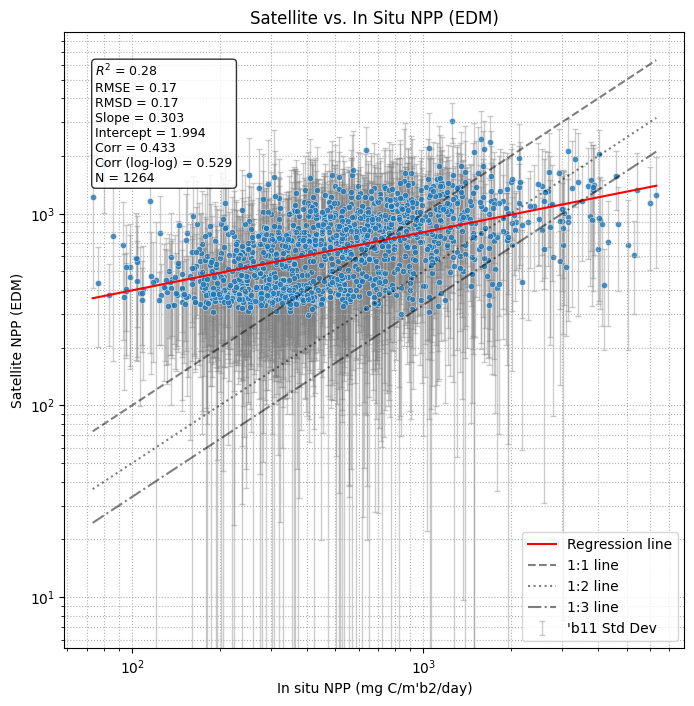

In [100]:
# --- EDM SECTION: STEP 2 (Unstacking & Spatial Averaging) ---

# Organize the flat predictions back into the original 3D grid format (station_obs, y_grid, x_grid)
# xmap[['station_obs', 'y_grid', 'x_grid']] = df_stacked[['station_obs', 'y_grid', 'x_grid']]

master_index = df_stacked.set_index(['station_obs', 'y_grid', 'x_grid']).index
df_pivot = xmap.set_index(['station_obs', 'y_grid', 'x_grid'])
df_pivot = df_pivot.reindex(master_index)

# Convert to a Dataset to hold our 3D grid results
prediction_ds = df_pivot['Predictions'].to_xarray().to_dataset(name='Satellite_NPP_Grid')
prediction_ds = prediction_ds.reindex_like(npp_norm)

# Spatial Averaging: 
# We calculate the mean and standard deviation across the 7x7 grid for each observation.
# This gives us a single 'Satellite NPP' value and an uncertainty estimate.

# 1. Ensure we only look at the predicted data
predicted_only = prediction_ds.where(~prediction_ds['Satellite_NPP_Grid'].isnull().all(dim=['y_grid', 'x_grid']), drop=True)

spatial_mean = prediction_ds['Satellite_NPP_Grid'].mean(dim=['y_grid', 'x_grid'], skipna=True)
spatial_std = prediction_ds['Satellite_NPP_Grid'].std(dim=['y_grid', 'x_grid'], skipna=True)

# Final Assembly
# Add the 1D results and the original in-situ data back into one object
prediction_ds['Integrated_NPP'] = npp_norm['Integrated_NPP']
prediction_ds['Satellite_NPP (EDM)'] = spatial_mean
prediction_ds['Satellite_NPP_std (EDM)'] = spatial_std

# Convert back to a 2D DataFrame for plotting and evaluation
plot_df = prediction_ds[['Integrated_NPP', 'Satellite_NPP (EDM)', 'Satellite_NPP_std (EDM)']].to_dataframe()
plot_df = plot_df.dropna(subset=['Integrated_NPP', 'Satellite_NPP (EDM)'])

# Plot results
model_name = "EDM"
fig, ax = plt.subplots(figsize=(8, 8))
make_scatter_plot(plot_df, model_name, ax=ax)
plt.show()

In [ ]:
# Import the worker initialization and trial wrapper from your edm_workers.py file
from edm_workers import init_worker, parallel_trial_wrapper

# --- 1. Define Search Parameters ---
# Use the predictor pool available in your dataset
predictor_pool = list(npp_norm.data_vars)[3:]
E = 2  # Embedding dimension (number of variables to combine)

# --- 2. Prepare Combinations ---
# Generate all possible combinations of variables for the given E
exhaustive_samples = [list(cols) for cols in combinations(predictor_pool, E)]
tasks = list(enumerate(exhaustive_samples))
n_total = len(tasks)

# --- 3. Execute Parallel Search ---
# The 'if __name__ == "__main__":' block is required for multiprocessing in notebooks
if __name__ == '__main__':
    print(f"Starting exhaustive E={E} search ({n_total:,} combinations)...")
    
    with concurrent.futures.ProcessPoolExecutor(
        max_workers=None, 
        initializer=init_worker,
        # Wrap npp_norm in a tuple (npp_norm,) so it counts as ONE argument
        initargs=((npp_norm,))
    ) as executor:
        
        results = list(tqdm(executor.map(parallel_trial_wrapper, tasks), total=n_total))

    # --- 4. Process and Rank Results ---
    # Filter out failed trials and convert to a DataFrame
    final_results = [r for r in results if r is not None]
    ensemble_df = pd.DataFrame(final_results)

    # Rank the models by Total Log-Log R^2
    if not ensemble_df.empty:
        ensemble_df = ensemble_df.sort_values('Total_r2', ascending=False)
        print("\nTop 10 Model Combinations:")
        display(ensemble_df.head(10))
    else:
        print("No valid results were returned from the trials.")

In [ ]:
#print('top 5 embeddings:')
ensemble_df_e2 = pd.read_csv('e2_results_xarray_out_of_sample.csv')
display(ensemble_df_e2)#.reset_index(drop=True).loc[:5, 'embedding'].tolist())

In [ ]:
#ensemble_df.to_csv('e2_results_xarray_out_of_sample.csv')

In [ ]:
from scipy.stats import ttest_ind

# 1. Setup
cohen_results = []

# Pre-process embeddings into sets
results_summary = ensemble_df.copy()
results_summary['embedding_list'] = results_summary['embedding'].apply(lambda x: set(s.strip() for s in x.split(',')))

print(f"Analyzing {len(predictor_pool)} variables using Cohen's d effect size...")

# 2. Loop through variables and regions
for var in tqdm(predictor_pool):
    # Identify models that contain this specific variable
    mask_with = results_summary['embedding_list'].apply(lambda x: var in x)
    
    models_with = results_summary[mask_with]
    models_without = results_summary[~mask_with]
    
    metric = f'Total_log_corr'
    
    data_with = models_with[metric].dropna()
    data_without = models_without[metric].dropna()
    
    if len(data_with) > 1 and len(data_without) > 1:
        # Stats for Cohen's d
        n1, n2 = len(data_with), len(data_without)
        m1, m2 = data_with.mean(), data_without.mean()
        s1, s2 = data_with.std(), data_without.std()
        
        # Calculate Pooled Standard Deviation
        pooled_std = np.sqrt(((n1 - 1) * s1**2 + (n2 - 1) * s2**2) / (n1 + n2 - 2))
        
        # Cohen's d formula
        if pooled_std > 0:
            d_val = (m1 - m2) / pooled_std
        else:
            d_val = 0
        
        # Keep t-test for significance filtering
        t_stat, p_val = ttest_ind(data_with, data_without, equal_var=False)
                    
        cohen_results.append({
            'variable': var,
            'cohens_d': d_val,
            't_stat': t_stat,
            'p_value': p_val,
            'mean_diff': m1 - m2,
            'n_with': n1,
            'significant': p_val < 0.05,
            'causal_driver': (d_val > 0 and p_val < 0.05)
        })

# 3. Create Summary DataFrame
stats_df = pd.DataFrame(cohen_results)

# Sort by Cohen's d (Magnitude of impact)
stats_df = stats_df.sort_values(by='cohens_d', ascending=False)

# Display the top drivers
display(stats_df.head(10))

In [ ]:
print('causal drivers:')
display(stats_df[stats_df.causal_driver==True])

print('not causal:')
display(stats_df[stats_df.causal_driver==False])

In [ ]:
# T-test for models with vs. without a variable

results_summary = ensemble_df

var_of_interest = 'wind_stress_curl_variance_14'

models_with_var = results_summary[results_summary['embedding'].apply(lambda x: var_of_interest in x)]
models_without_var = results_summary[~results_summary['embedding'].apply(lambda x: var_of_interest in x)]

fig, ax = plt.subplots(1, figsize=(6,5))

for i, region in enumerate(['Total']):
    ax.hist(models_with_var[f'{region}_log_corr'], bins=50, alpha=0.5, color='tab:blue', label=f'With {var_of_interest}')
    ax.axvline(models_with_var[f'{region}_log_corr'].mean(), c='tab:blue')
    ax2 = ax.twinx()
    ax2.hist(models_without_var[f'{region}_log_corr'], bins=50, alpha=0.3, color='tab:orange', label=f'Without {var_of_interest}')
    ax2.axvline(models_without_var[f'{region}_log_corr'].mean(), c='tab:orange')
    
    # Add legend
    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
    
    plt.title(f'Causality Test \n({region})')
    ax.set_xlabel('Prediction Skill (ρ)')
    ax.set_ylabel('Frequency (models with)')
    ax2.set_ylabel('Frequency (models without)')
    
    # T-test for significance
    log_corr_with = models_with_var[f'{region}_log_corr'].dropna()
    log_corr_without = models_without_var[f'{region}_log_corr'].dropna()
    t_stat, p_val = ttest_ind(log_corr_with, log_corr_without, equal_var=False)
    
    if t_stat > 0:
        significance_text = (
            f"Mean log_corr is "
            + r"$\mathbf{significantly\ higher}$"
            + f" in models with {var_of_interest}"
            )
    else:
        significance_text = (
            f"Mean log_corr is "
            + r"$\mathbf{significantly\ lower}$"
            + f" in models with {var_of_interest}"
            )
    
    stats_text = f"{significance_text}\nT-statistic: {t_stat:.3f}\nP-value: {p_val:.3e}\n"

    # Wrap long lines to ~40 characters
    import textwrap
    stats_text_wrapped = "\n".join(textwrap.wrap(stats_text, width=39))
    
    # Add the box
    ax.text(
        0.025, 0.81, stats_text_wrapped,
        transform=ax.transAxes,
        fontsize=9,
        verticalalignment='top',
        horizontalalignment='left',
        bbox=dict(boxstyle='round,pad=0.4', facecolor='white', edgecolor='lightgray', alpha=0.8)
    )
    ax.grid(False)
    ax2.grid(False)

fig.tight_layout()
plt.show()

In [ ]:
models_with_var[models_with_var.Total_log_corr > 0.4].embedding.tolist()

In [ ]:
ensemble_df[ensemble_df.Total_log_corr > 0.4].embedding.tolist()

In [ ]:
df_stacked

In [ ]:
## Visualize top-performing embedding

# 1. Define the variables for the manifold
x_var = 'wind_stress_curl_mean_0'
y_var = 'wind_stress_curl_variance_14'
color_var = 'Integrated_NPP'
pred_var = 'Predictions'

# 2. Filter data for plotting (remove NaNs and extreme outliers for better color scaling)
# Using log for NPP color mapping is often better for skewed biological data
plot_data = df_stacked[[x_var, y_var, color_var, pred_var]].dropna().copy()
plot_data['log_NPP'] = np.log10(plot_data[color_var])
plot_data['log_Pred'] = np.log10(plot_data[pred_var].clip(lower=1e-1)) # clip to avoid log(0)

# 3. Create the Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7), sharex=True, sharey=True)

# Plot A: Ground Truth Manifold
sc1 = ax1.scatter(plot_data[x_var], plot_data[y_var], 
                  c=plot_data['log_NPP'], cmap='viridis', 
                  s=1, alpha=0.5, rasterized=True)
ax1.set_title(f'Observed NPP Manifold\n({x_var} vs {y_var})', fontsize=14)
ax1.set_xlabel('Wind Stress Curl (Mean 0)', fontsize=12)
ax1.set_ylabel('Wind Stress Curl (Var 14)', fontsize=12)

# Plot B: EDM Predicted Manifold
sc2 = ax2.scatter(plot_data[x_var], plot_data[y_var], 
                  c=plot_data['log_Pred'], cmap='viridis', 
                  s=1, alpha=0.5, rasterized=True)
ax2.set_title(f'EDM Reconstructed Manifold\n({pred_var})', fontsize=14)
ax2.set_xlabel('Wind Stress Curl (Mean 0)', fontsize=12)

# Add Colorbar
cbar = fig.colorbar(sc2, ax=[ax1, ax2], label='$\log_{10}$(Integrated NPP)')
plt.suptitle('State-Space Reconstruction of NPP from Wind Stress Curl', fontsize=16, y=1.02)

plt.show()

In [ ]:
# Import the worker initialization and trial wrapper from your edm_workers.py file
from edm_workers import init_worker, parallel_trial_wrapper

# --- 1. Define Search Parameters ---
# Use the predictor pool available in your dataset
predictor_pool = list(npp_norm.data_vars)[3:]
E = 3  # Embedding dimension (number of variables to combine)

# --- 2. Prepare Combinations ---
# Generate all possible combinations of variables for the given E
exhaustive_samples = [list(cols) for cols in combinations(predictor_pool, E)]
tasks = list(enumerate(exhaustive_samples))
n_total = len(tasks)

# --- 3. Execute Parallel Search ---
# The 'if __name__ == "__main__":' block is required for multiprocessing in notebooks
if __name__ == '__main__':
    print(f"Starting exhaustive E={E} search ({n_total:,} combinations)...")
    
    with concurrent.futures.ProcessPoolExecutor(
        max_workers=None, 
        initializer=init_worker,
        # Wrap npp_norm in a tuple (npp_norm,) so it counts as ONE argument
        initargs=((npp_norm,))
    ) as executor:
        
        results = list(tqdm(executor.map(parallel_trial_wrapper, tasks), total=n_total))

    # --- 4. Process and Rank Results ---
    # Filter out failed trials and convert to a DataFrame
    final_results = [r for r in results if r is not None]
    ensemble_df = pd.DataFrame(final_results)

    # Rank the models by Total Log-Log R^2
    if not ensemble_df.empty:
        ensemble_df = ensemble_df.sort_values('Total_r2', ascending=False)
        print("\nTop 10 Model Combinations:")
        display(ensemble_df.head(10))
    else:
        print("No valid results were returned from the trials.")

In [ ]:
# ensemble_df.to_csv('e3_results_xarray_out_of_sample.csv')

In [ ]:
print('top 5 embeddings:')
display(ensemble_df.reset_index(drop=True).loc[:5, 'embedding'].tolist())

In [ ]:
from scipy.stats import ttest_ind

# 1. Setup
cohen_results = []

# Pre-process embeddings into sets
results_summary = ensemble_df.copy()
results_summary['embedding_list'] = results_summary['embedding'].apply(lambda x: set(s.strip() for s in x.split(',')))

print(f"Analyzing {len(predictor_pool)} variables using Cohen's d effect size...")

# 2. Loop through variables and regions
for var in tqdm(predictor_pool):
    # Identify models that contain this specific variable
    mask_with = results_summary['embedding_list'].apply(lambda x: var in x)
    
    models_with = results_summary[mask_with]
    models_without = results_summary[~mask_with]
    
    metric = f'Total_log_corr'
    
    data_with = models_with[metric].dropna()
    data_without = models_without[metric].dropna()
    
    if len(data_with) > 1 and len(data_without) > 1:
        # Stats for Cohen's d
        n1, n2 = len(data_with), len(data_without)
        m1, m2 = data_with.mean(), data_without.mean()
        s1, s2 = data_with.std(), data_without.std()
        
        # Calculate Pooled Standard Deviation
        pooled_std = np.sqrt(((n1 - 1) * s1**2 + (n2 - 1) * s2**2) / (n1 + n2 - 2))
        
        # Cohen's d formula
        if pooled_std > 0:
            d_val = (m1 - m2) / pooled_std
        else:
            d_val = 0
        
        # Keep t-test for significance filtering
        t_stat, p_val = ttest_ind(data_with, data_without, equal_var=False)
                    
        cohen_results.append({
            'variable': var,
            'cohens_d': d_val,
            't_stat': t_stat,
            'p_value': p_val,
            'mean_diff': m1 - m2,
            'n_with': n1,
            'significant': p_val < 0.05,
            'causal_driver': (d_val > 0 and p_val < 0.05)
        })

# 3. Create Summary DataFrame
stats_df = pd.DataFrame(cohen_results)

# Sort by Cohen's d (Magnitude of impact)
stats_df = stats_df.sort_values(by='cohens_d', ascending=False)

# Display the top drivers
display(stats_df.head(10))

In [ ]:
print('causal drivers:')
display(stats_df[stats_df.causal_driver==True])

print('not causal:')
display(stats_df[stats_df.causal_driver==False])

In [ ]:
# T-test for models with vs. without a variable

results_summary = ensemble_df

var_of_interest = 'wind_stress_curl_variance_14'

models_with_var = results_summary[results_summary['embedding'].apply(lambda x: var_of_interest in x)]
models_without_var = results_summary[~results_summary['embedding'].apply(lambda x: var_of_interest in x)]

fig, ax = plt.subplots(1, figsize=(6,5))

for i, region in enumerate(['Total']):
    ax.hist(models_with_var[f'{region}_log_corr'], bins=50, alpha=0.5, color='tab:blue', label=f'With {var_of_interest}')
    ax.axvline(models_with_var[f'{region}_log_corr'].mean(), c='tab:blue')
    ax2 = ax.twinx()
    ax2.hist(models_without_var[f'{region}_log_corr'], bins=50, alpha=0.3, color='tab:orange', label=f'Without {var_of_interest}')
    ax2.axvline(models_without_var[f'{region}_log_corr'].mean(), c='tab:orange')
    
    # Add legend
    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
    
    plt.title(f'Causality Test \n({region})')
    ax.set_xlabel('Prediction Skill (ρ)')
    ax.set_ylabel('Frequency (models with)')
    ax2.set_ylabel('Frequency (models without)')
    
    # T-test for significance
    log_corr_with = models_with_var[f'{region}_log_corr'].dropna()
    log_corr_without = models_without_var[f'{region}_log_corr'].dropna()
    t_stat, p_val = ttest_ind(log_corr_with, log_corr_without, equal_var=False)
    
    if t_stat > 0:
        significance_text = (
            f"Mean log_corr is "
            + r"$\mathbf{significantly\ higher}$"
            + f" in models with {var_of_interest}"
            )
    else:
        significance_text = (
            f"Mean log_corr is "
            + r"$\mathbf{significantly\ lower}$"
            + f" in models with {var_of_interest}"
            )
    
    stats_text = f"{significance_text}\nT-statistic: {t_stat:.3f}\nP-value: {p_val:.3e}\n"

    # Wrap long lines to ~40 characters
    import textwrap
    stats_text_wrapped = "\n".join(textwrap.wrap(stats_text, width=39))
    
    # Add the box
    ax.text(
        0.025, 0.81, stats_text_wrapped,
        transform=ax.transAxes,
        fontsize=9,
        verticalalignment='top',
        horizontalalignment='left',
        bbox=dict(boxstyle='round,pad=0.4', facecolor='white', edgecolor='lightgray', alpha=0.8)
    )
    ax.grid(False)
    ax2.grid(False)

fig.tight_layout()
plt.show()

In [ ]:
from collections import Counter

best_combos = ensemble_df[ensemble_df.Total_log_corr > 0.4]

all_vars = []
for i, emb in enumerate(best_combos['embedding']):
    # Split by comma and strip whitespace
    vars_in_model = [v.strip() for v in str(emb).split(',')]
    all_vars.extend(vars_in_model)
counts = Counter(all_vars)
freq_df = pd.DataFrame.from_dict(counts, orient='index', columns=['count']).reset_index()
freq_df = freq_df.sort_values(by='count', ascending=False)
freq_df.columns = ['variable', 'count']

fig, ax = plt.subplots()
ax.barh(freq_df['variable'], freq_df['count'], color='skyblue')
ax.set_xlabel('Frequency in Top Models (rho > 0.4)')
ax.set_title('Most Frequent Variables in High-Performing E=3 Models')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [ ]:
df_stacked

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

# 1. Define the variables for the E=3 manifold
x_var = 'v10_mean_7'
y_var = 'wind_stress_curl_value_7'
z_var = 'wind_stress_curl_variance_14'
color_var = 'Integrated_NPP'
pred_var = 'Predictions'

# 2. Filter and prepare data
plot_data = df_stacked[[x_var, y_var, z_var, color_var, pred_var]].dropna().copy()
plot_data['log_NPP'] = np.log10(plot_data[color_var])
plot_data['log_Pred'] = np.log10(plot_data[pred_var].clip(lower=1e-1))

# 3. Create 3D Visualization
fig = plt.figure(figsize=(18, 8))

# --- Plot A: Observed NPP Manifold ---
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
sc1 = ax1.scatter(plot_data[x_var], plot_data[y_var], plot_data[z_var], 
                  c=plot_data['log_NPP'], cmap='viridis', 
                  s=2, alpha=0.4, depthshade=True)
ax1.set_title(f'Observed NPP Manifold\n($log_{10}$ NPP)', fontsize=14)
ax1.set_xlabel(x_var)
ax1.set_ylabel(y_var)
ax1.set_zlabel(z_var)

# --- Plot B: EDM Predicted Manifold ---
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
sc2 = ax2.scatter(plot_data[x_var], plot_data[y_var], plot_data[z_var], 
                  c=plot_data['log_Pred'], cmap='viridis', 
                  s=2, alpha=0.4, depthshade=True)
ax2.set_title(f'EDM Reconstructed Manifold\n(log_{10} Predictions)', fontsize=14)
ax2.set_xlabel(x_var)
ax2.set_ylabel(y_var)
ax2.set_zlabel(z_var)

# Synchronize viewing angles (adjust these to find the best perspective)
ax1.view_init(elev=20, azim=45)
ax2.view_init(elev=20, azim=45)

# Add Colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
fig.colorbar(sc2, cax=cbar_ax, label='log_{10}(Integrated NPP)')

plt.suptitle(f'3D State-Space Reconstruction: {x_var}, {y_var}, {z_var}', fontsize=16)
plt.show()